Processing file: cleaned_cleaned_cleaned_Steadfast_505H-10_30-11_07.csv


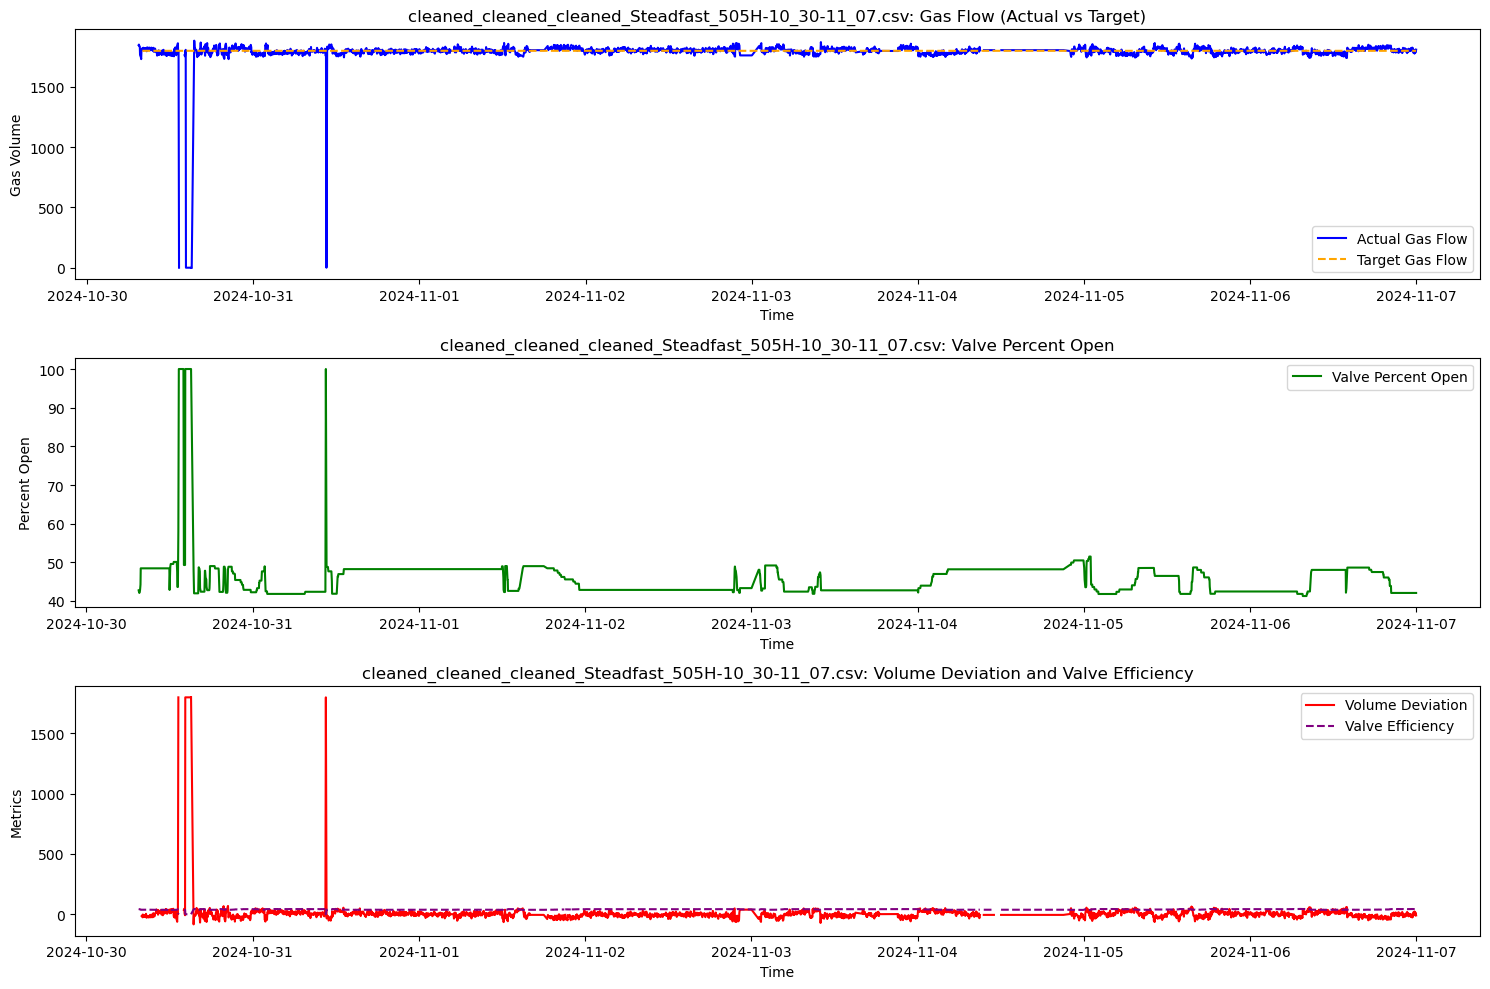

Processing file: cleaned_cleaned_cleaned_Courageous_729H-09_25-09_28.csv


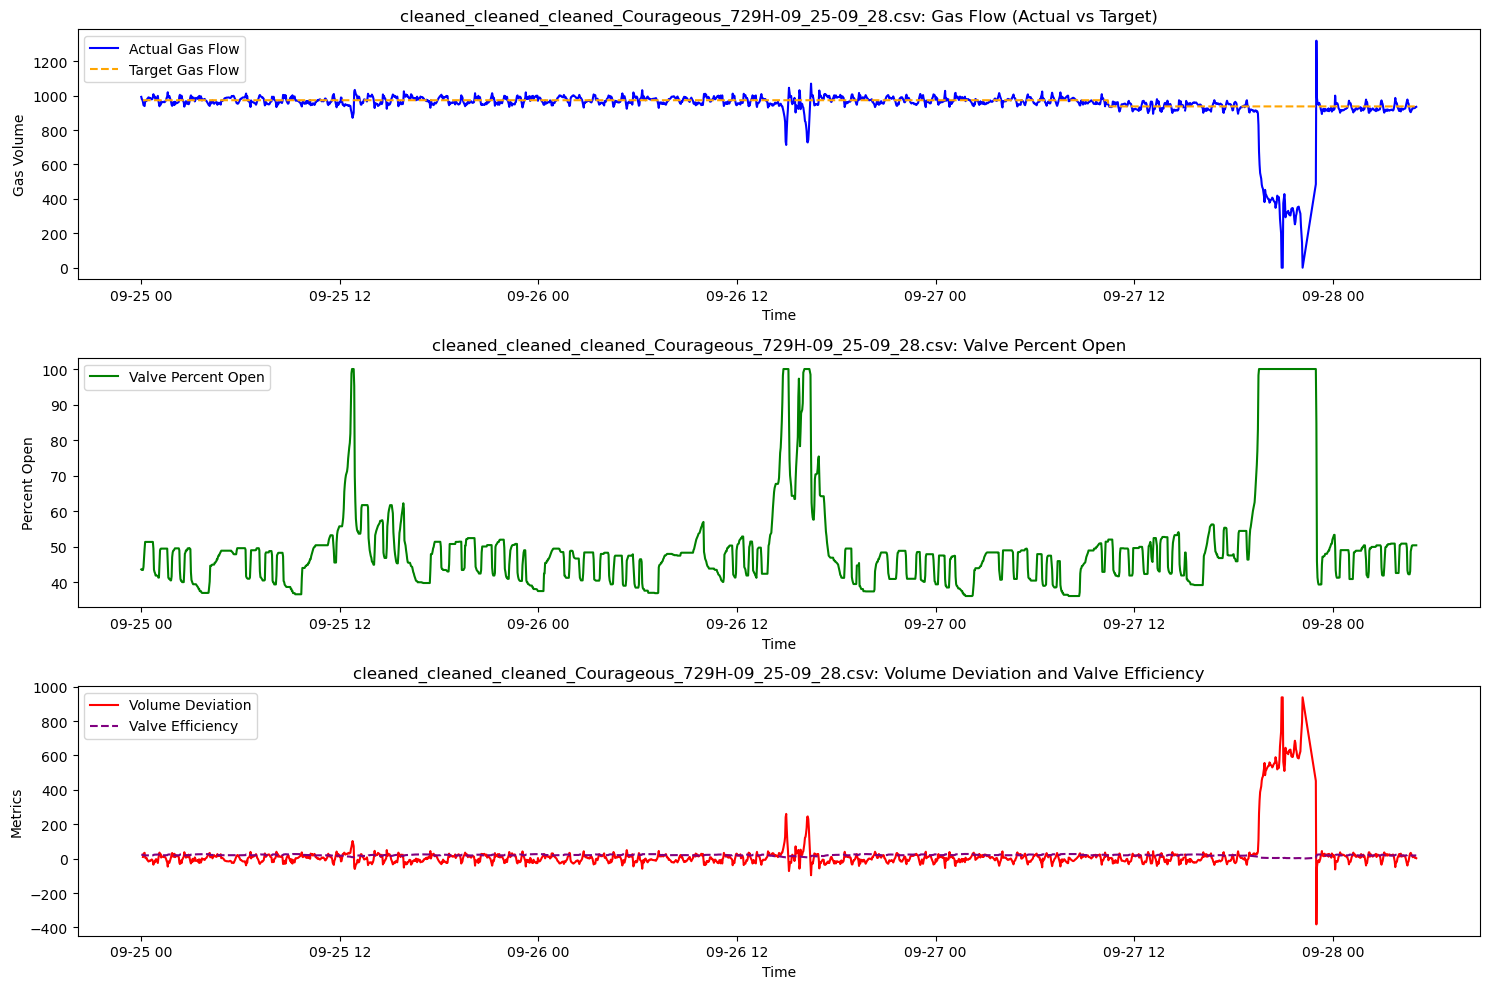

Processing file: cleaned_cleaned_Valiant_505H-09_22-09_30.csv


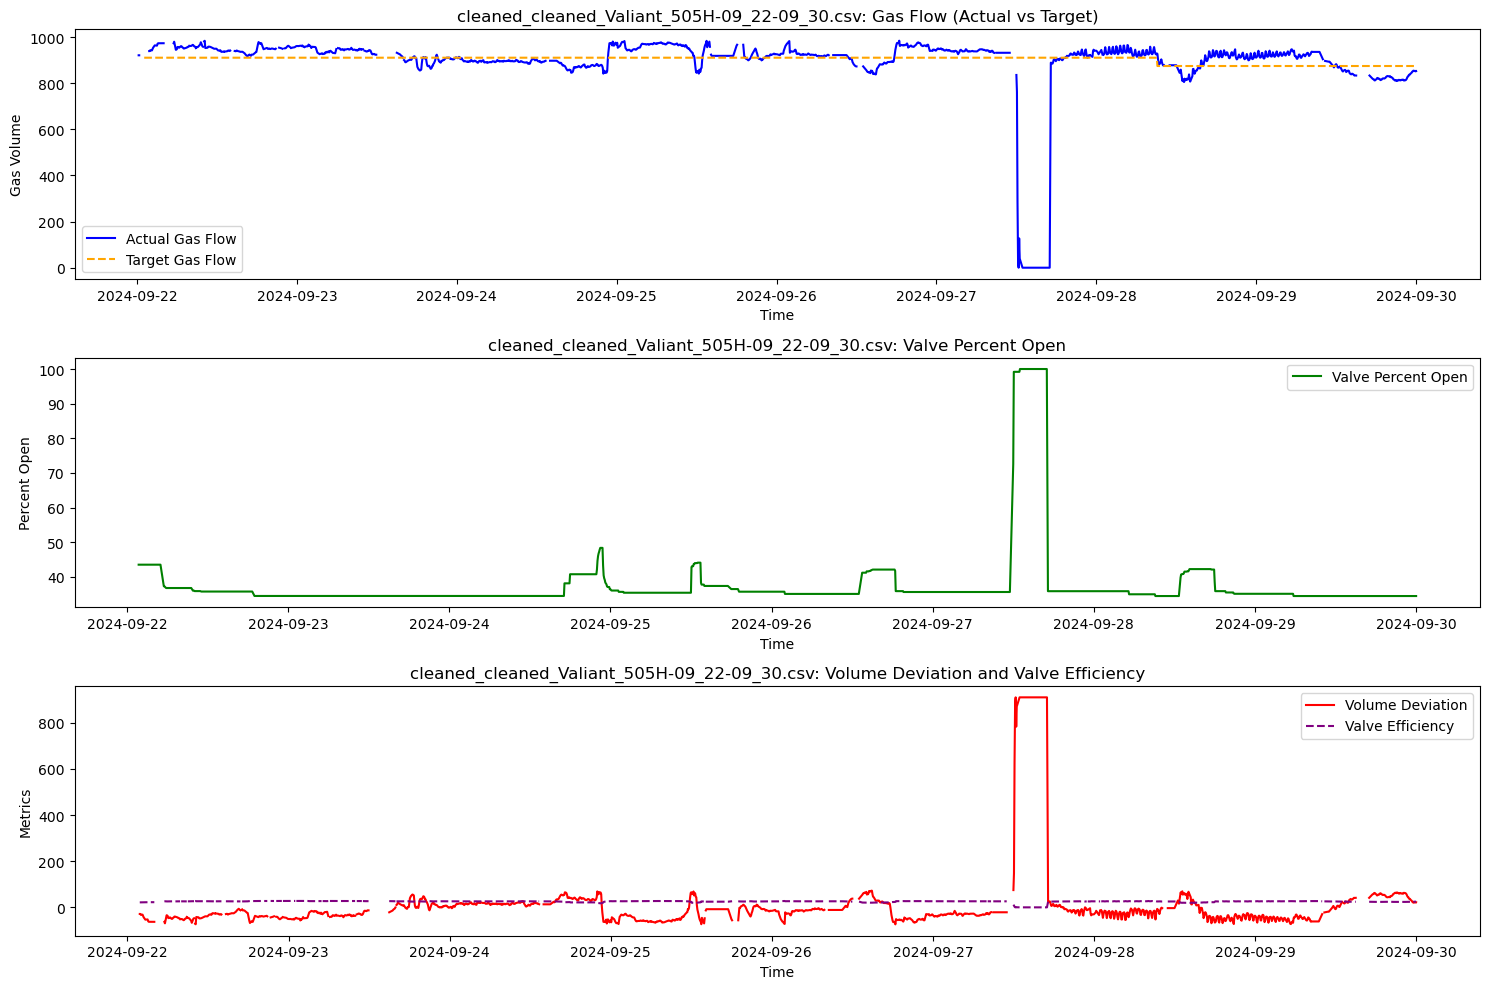

Processing file: cleaned_cleaned_cleaned_Ruthless_745H-10_01-10_08.csv


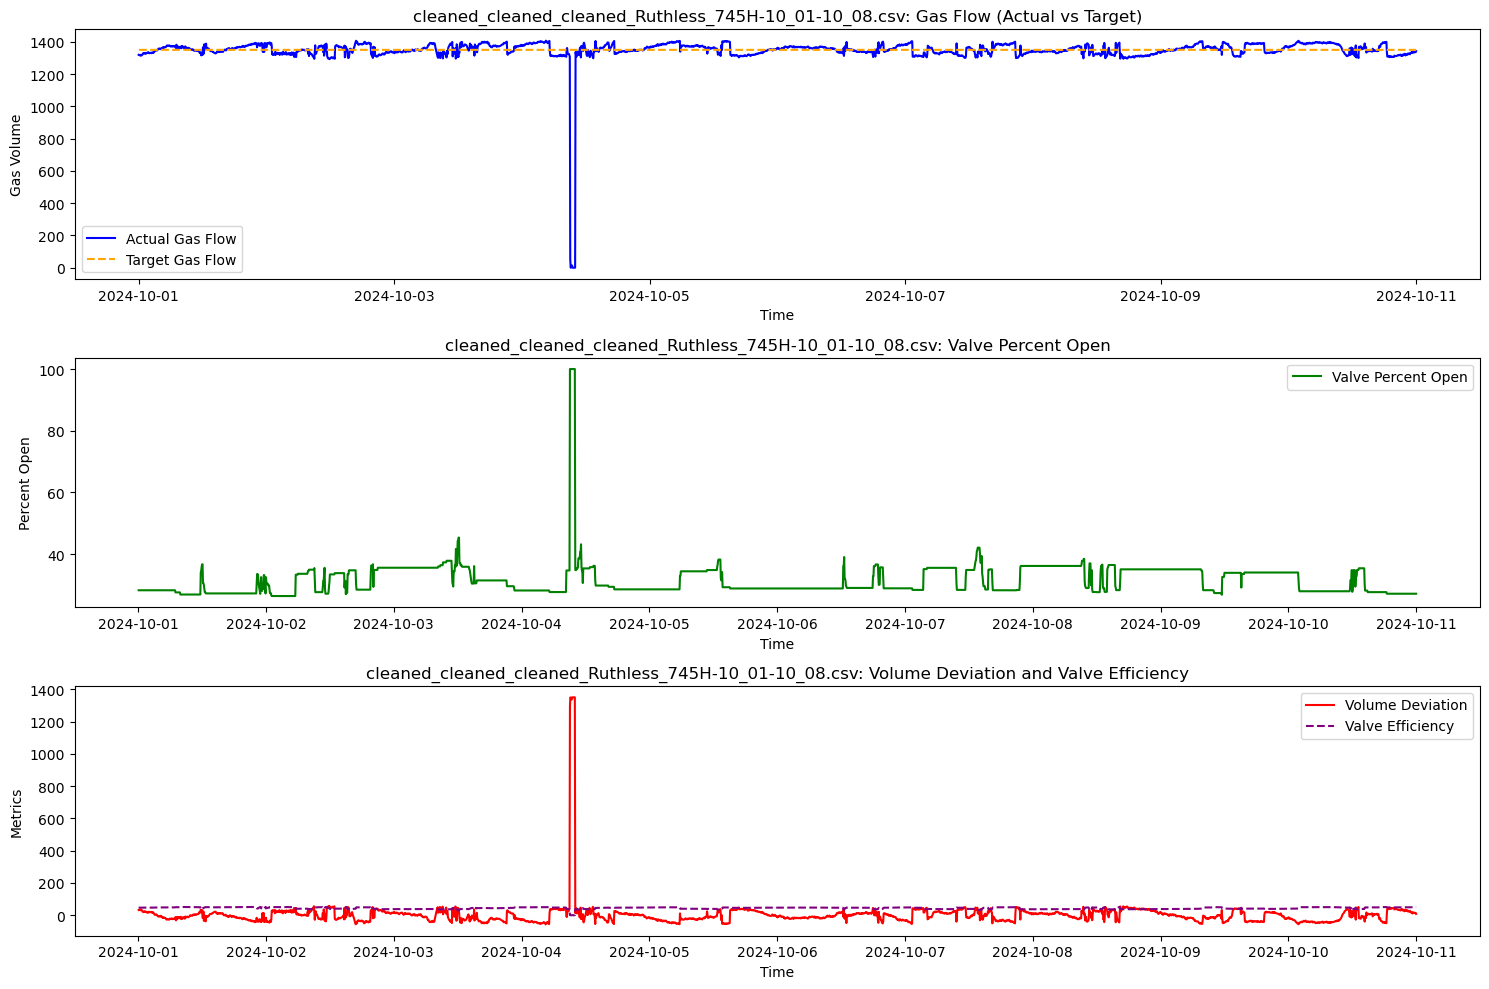

Processing file: cleaned_cleaned_Fearless_709H-10_31-11_07.csv


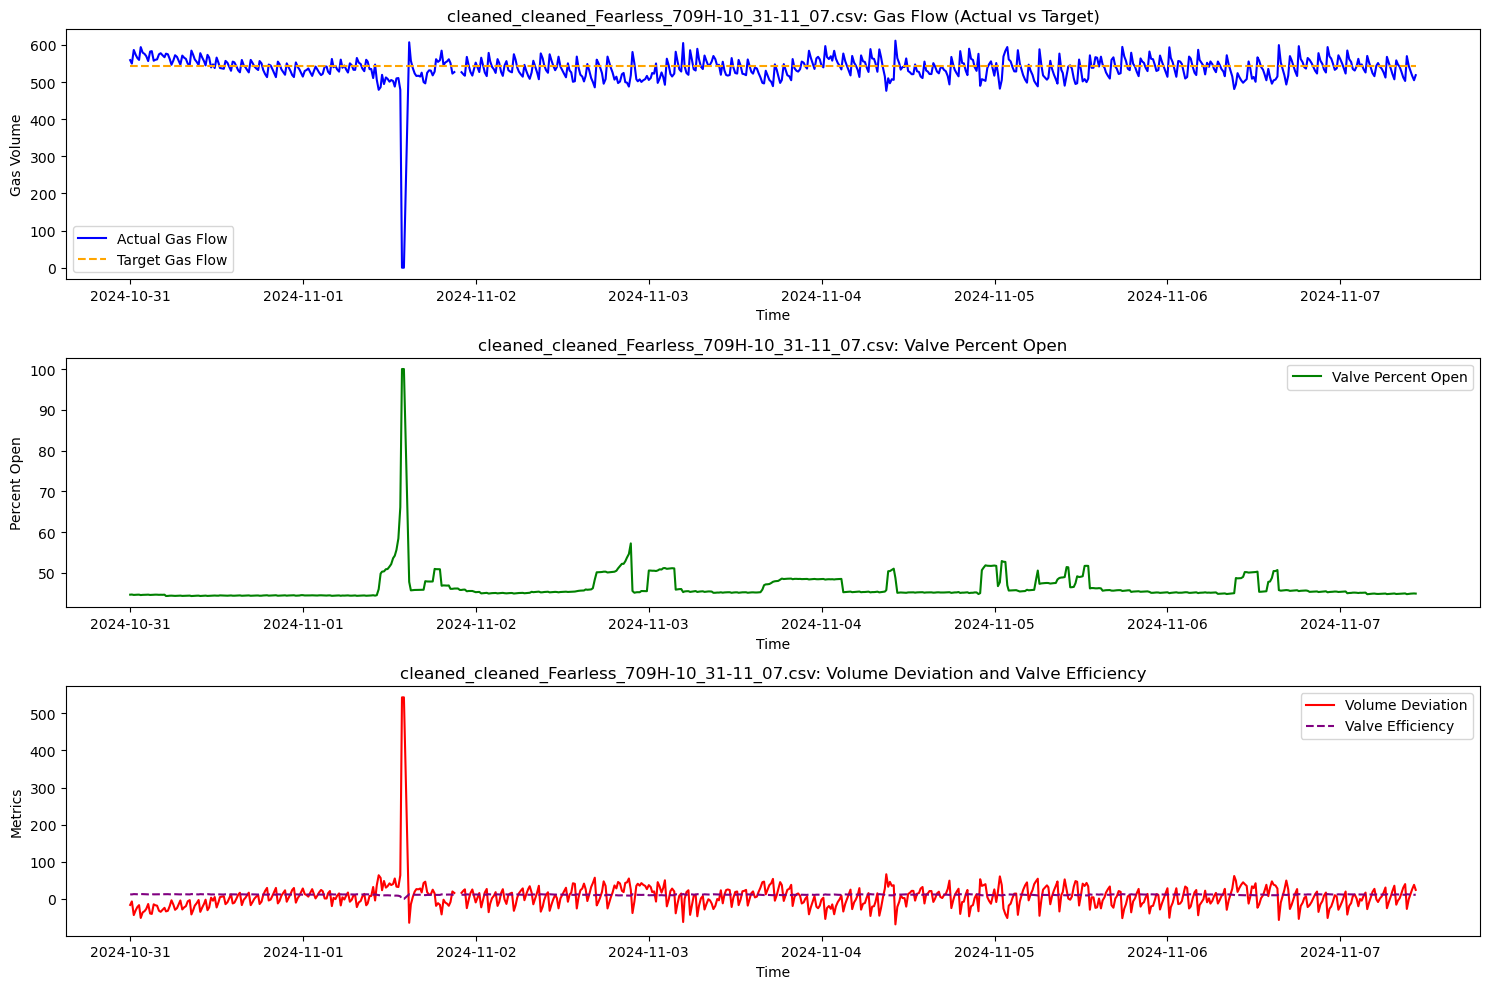

Processing file: cleaned_Noble_4H-10_24-10_29.csv


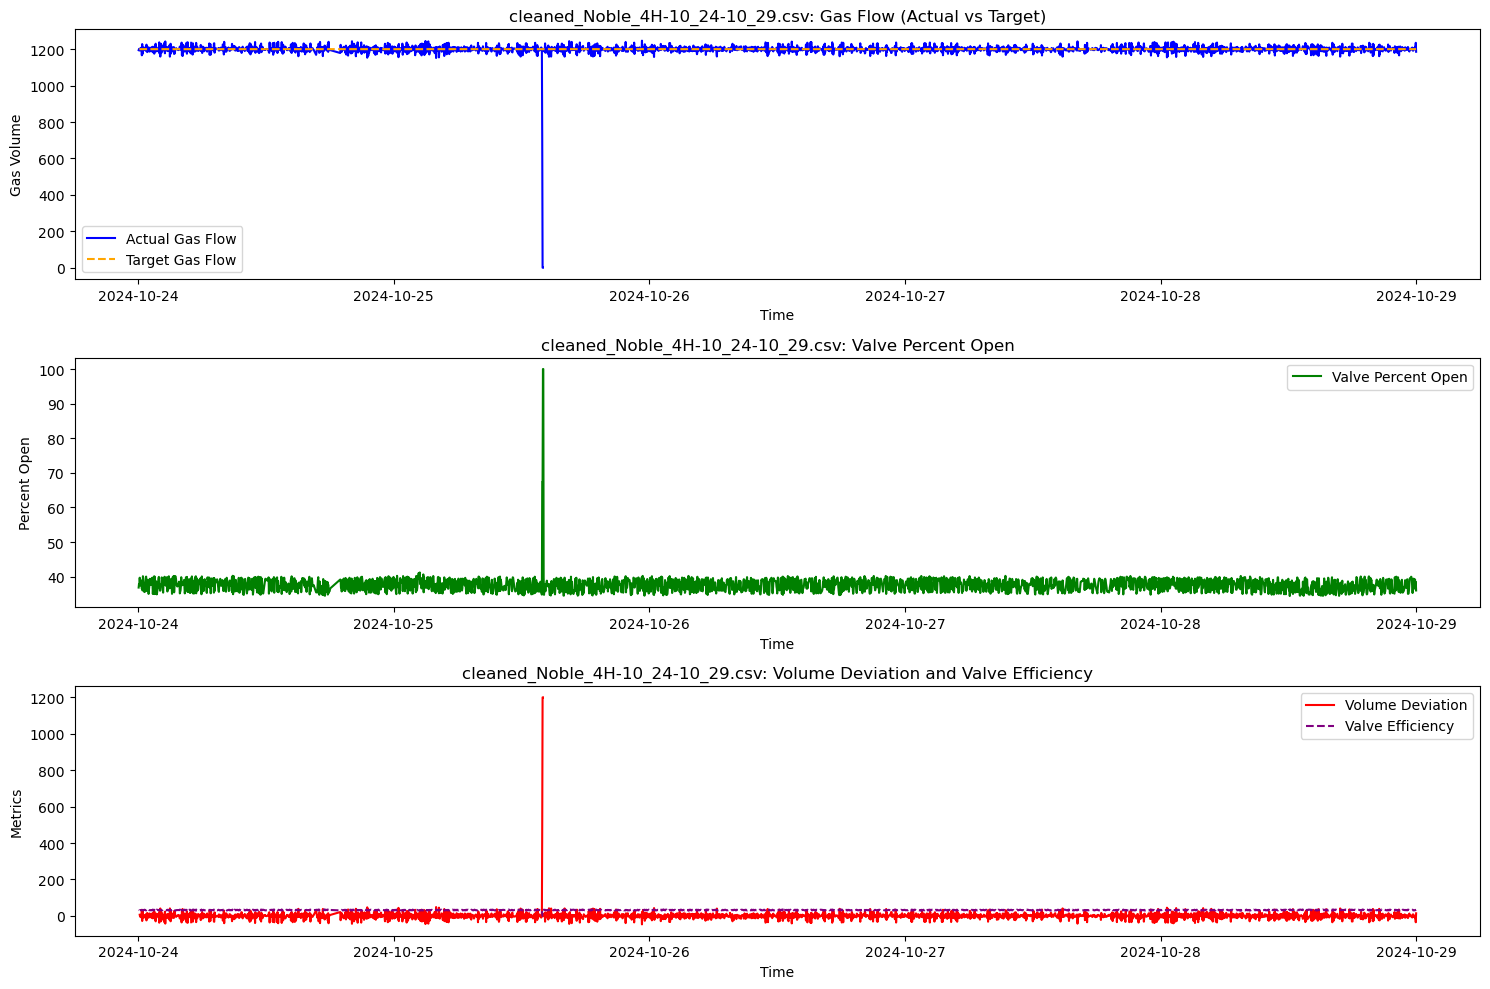

Processing file: cleaned_cleaned_Bold_744H-10_31-11_07.csv


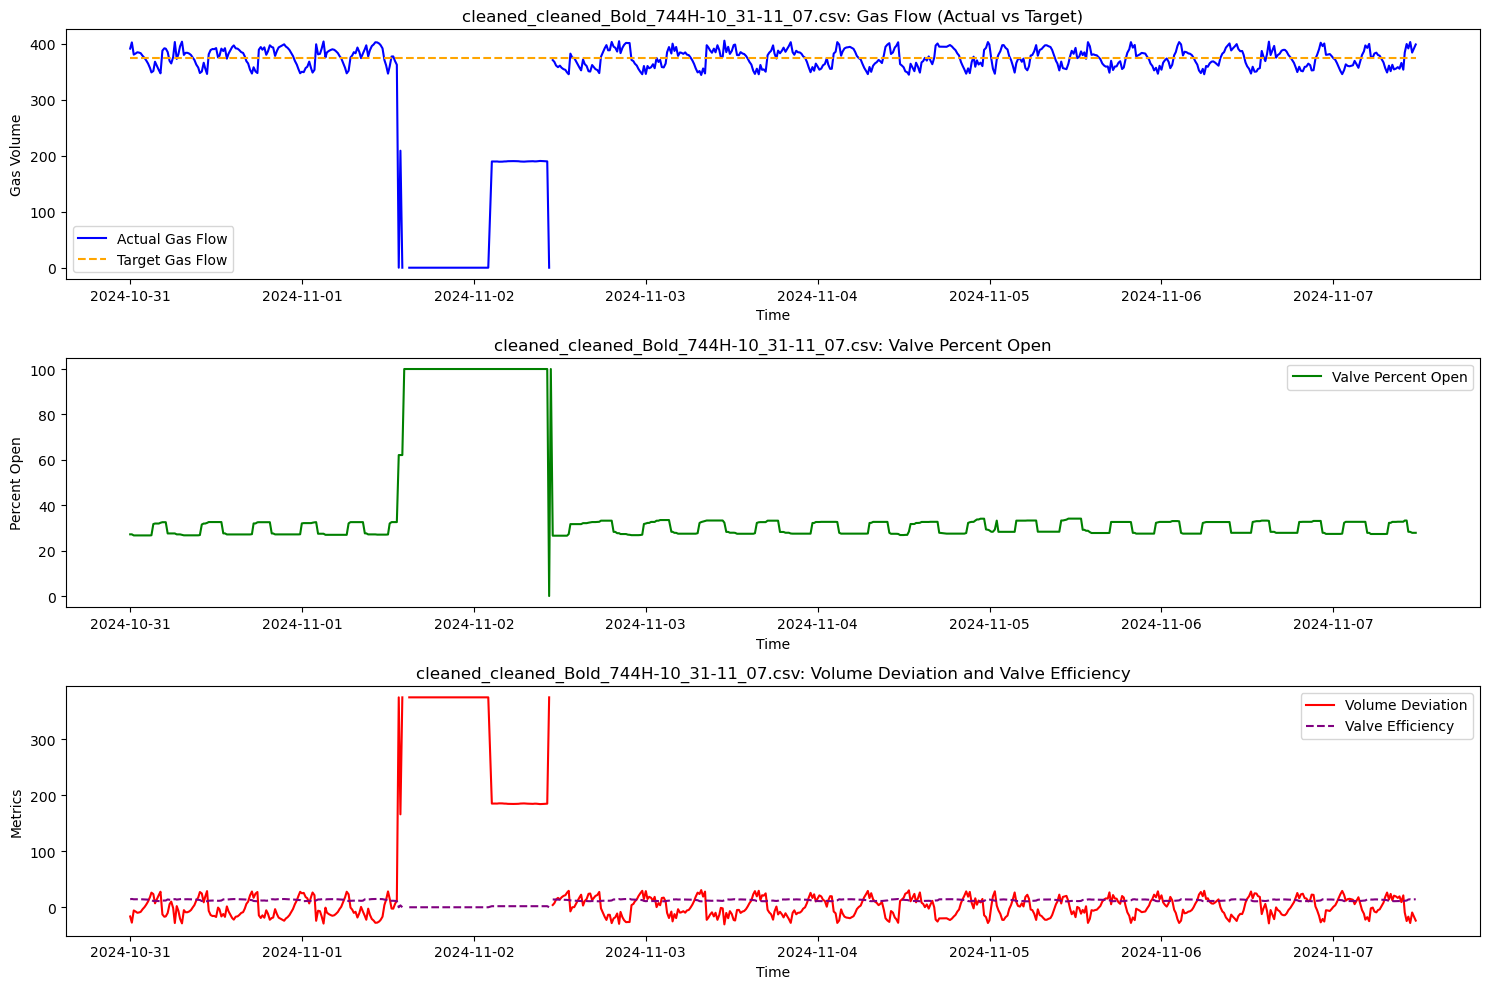

Processing file: cleaned_Valiant_505H-09_22-09_30.csv


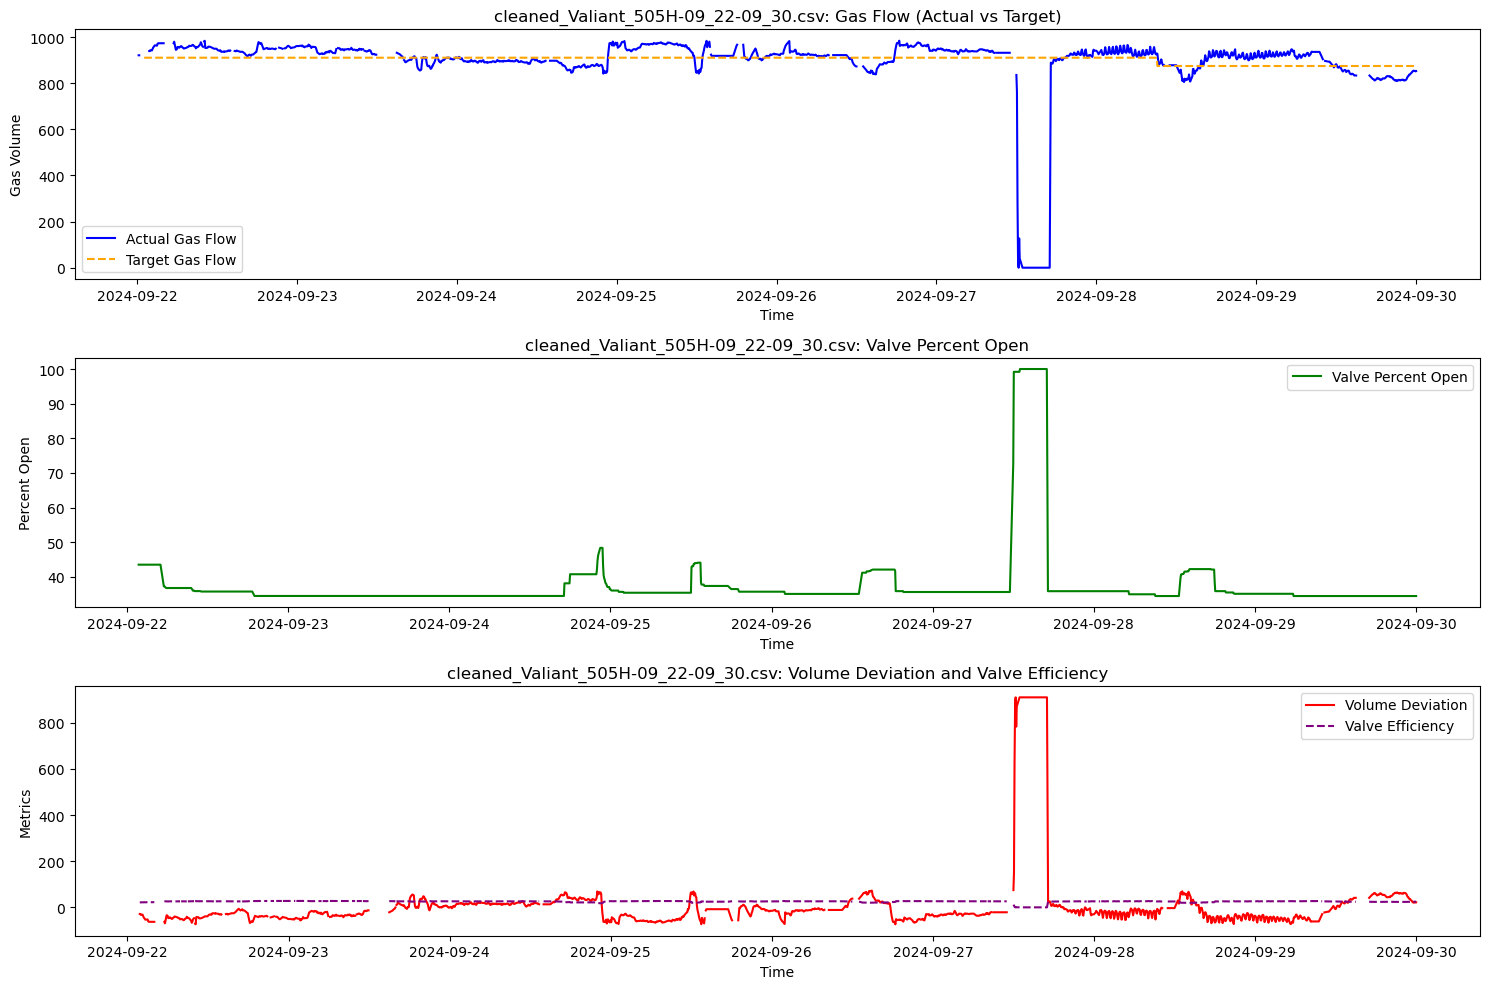

Processing file: cleaned_cleaned_Resolute_728H-10_14-10_21.csv


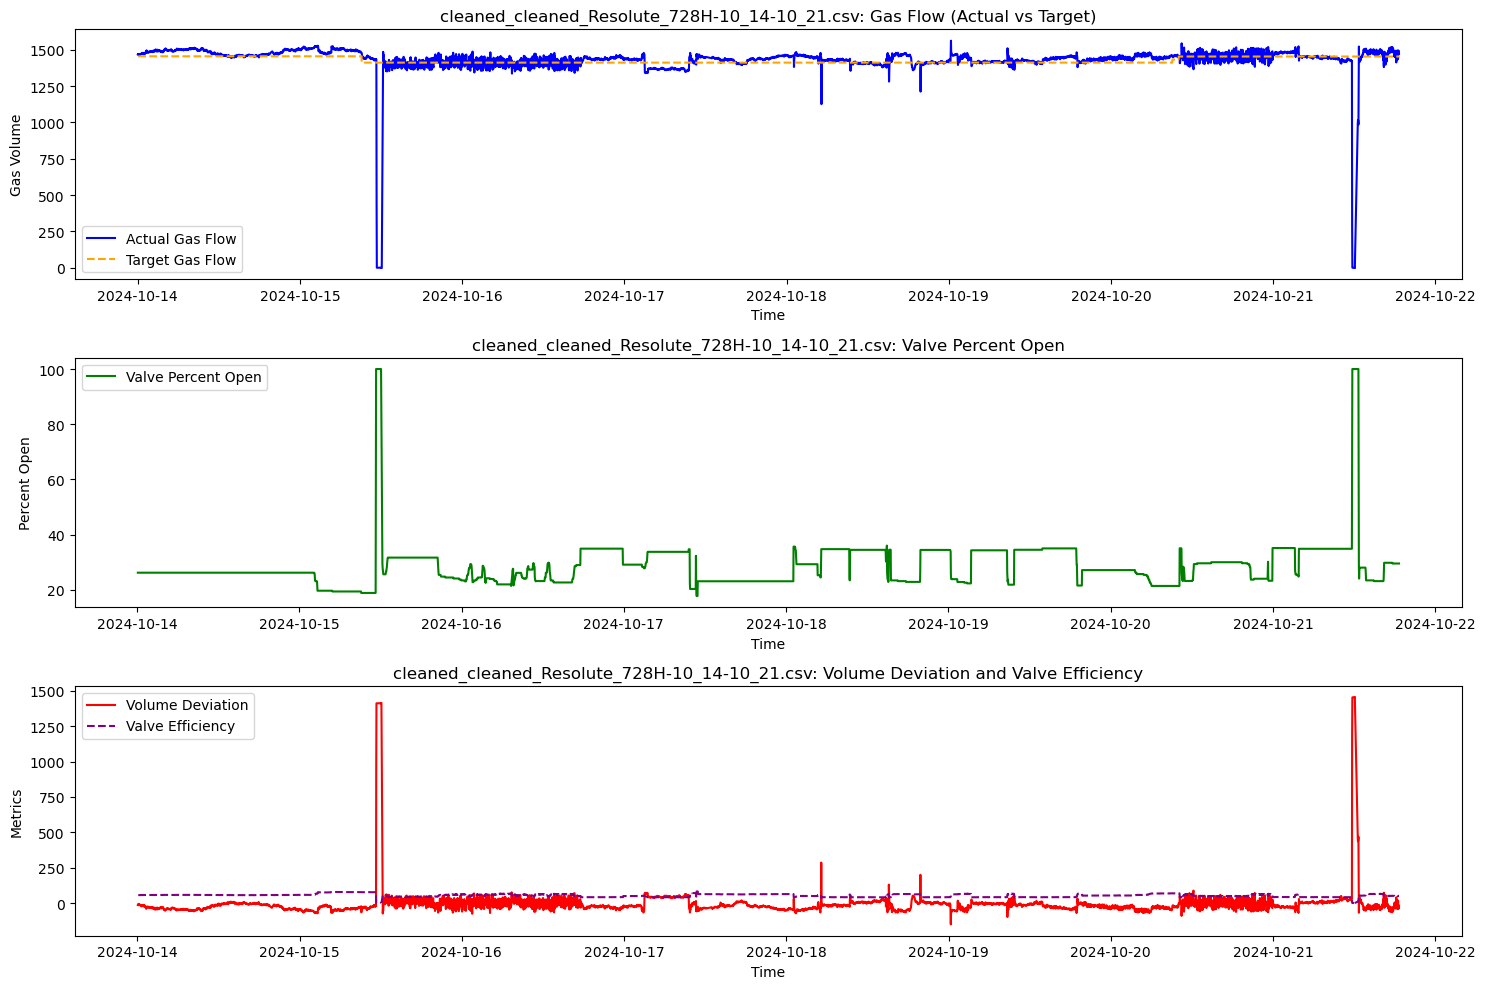

Processing file: cleaned_cleaned_Courageous_729H-09_25-09_28.csv


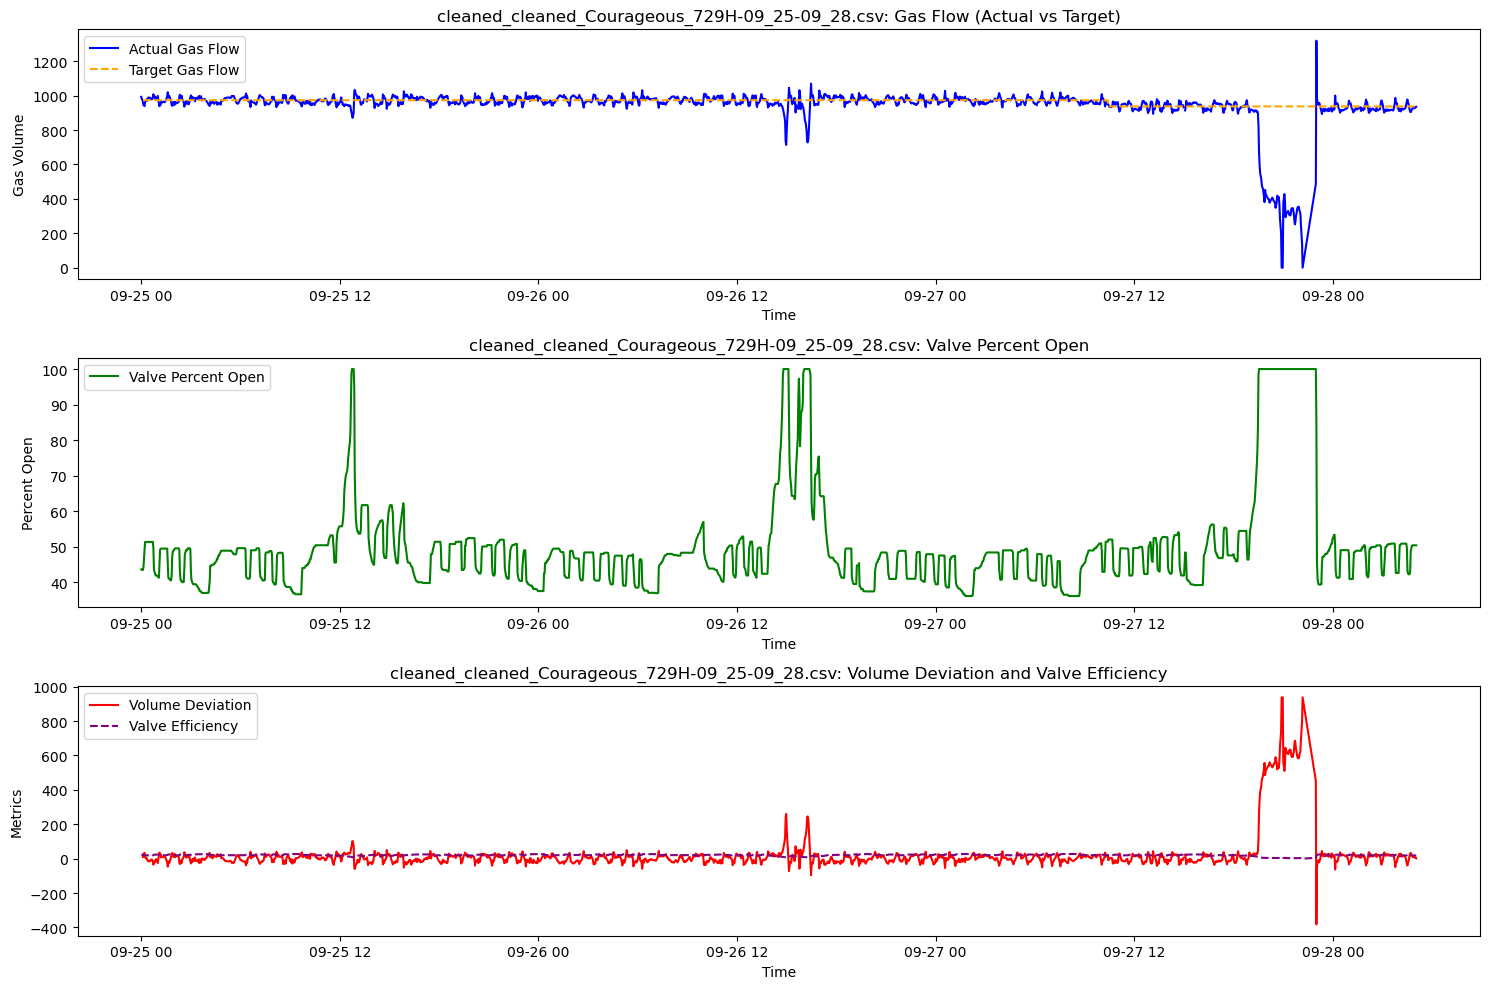

Processing file: cleaned_Ruthless_745H-10_01-10_08.csv


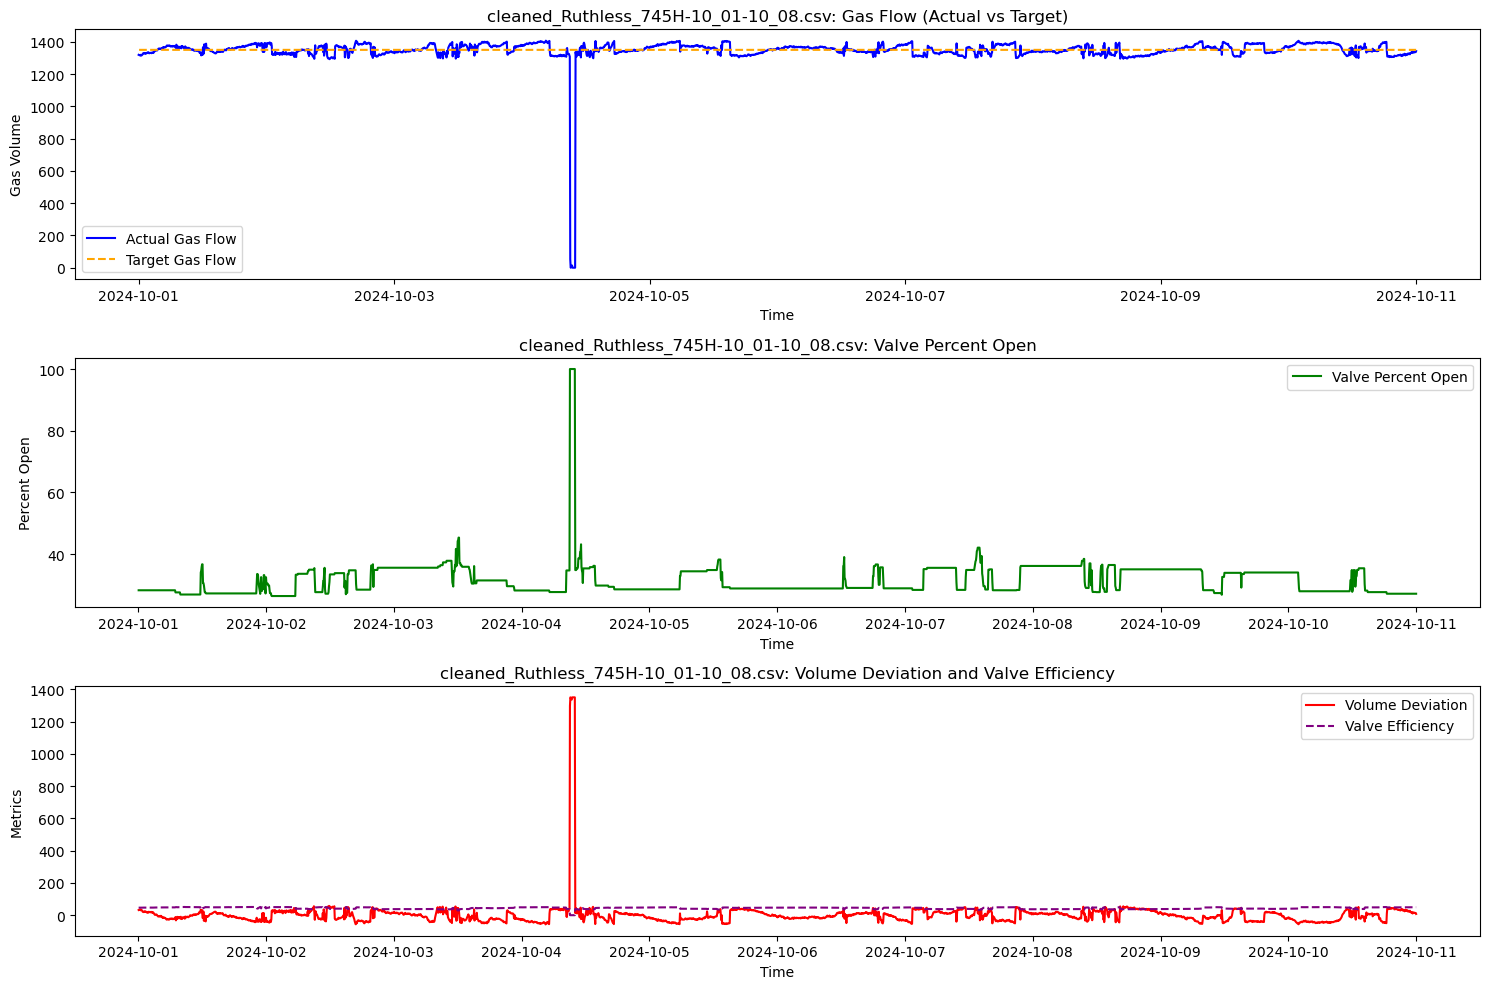

Processing file: cleaned_cleaned_cleaned_Gallant_102H-10_04-10_11.csv


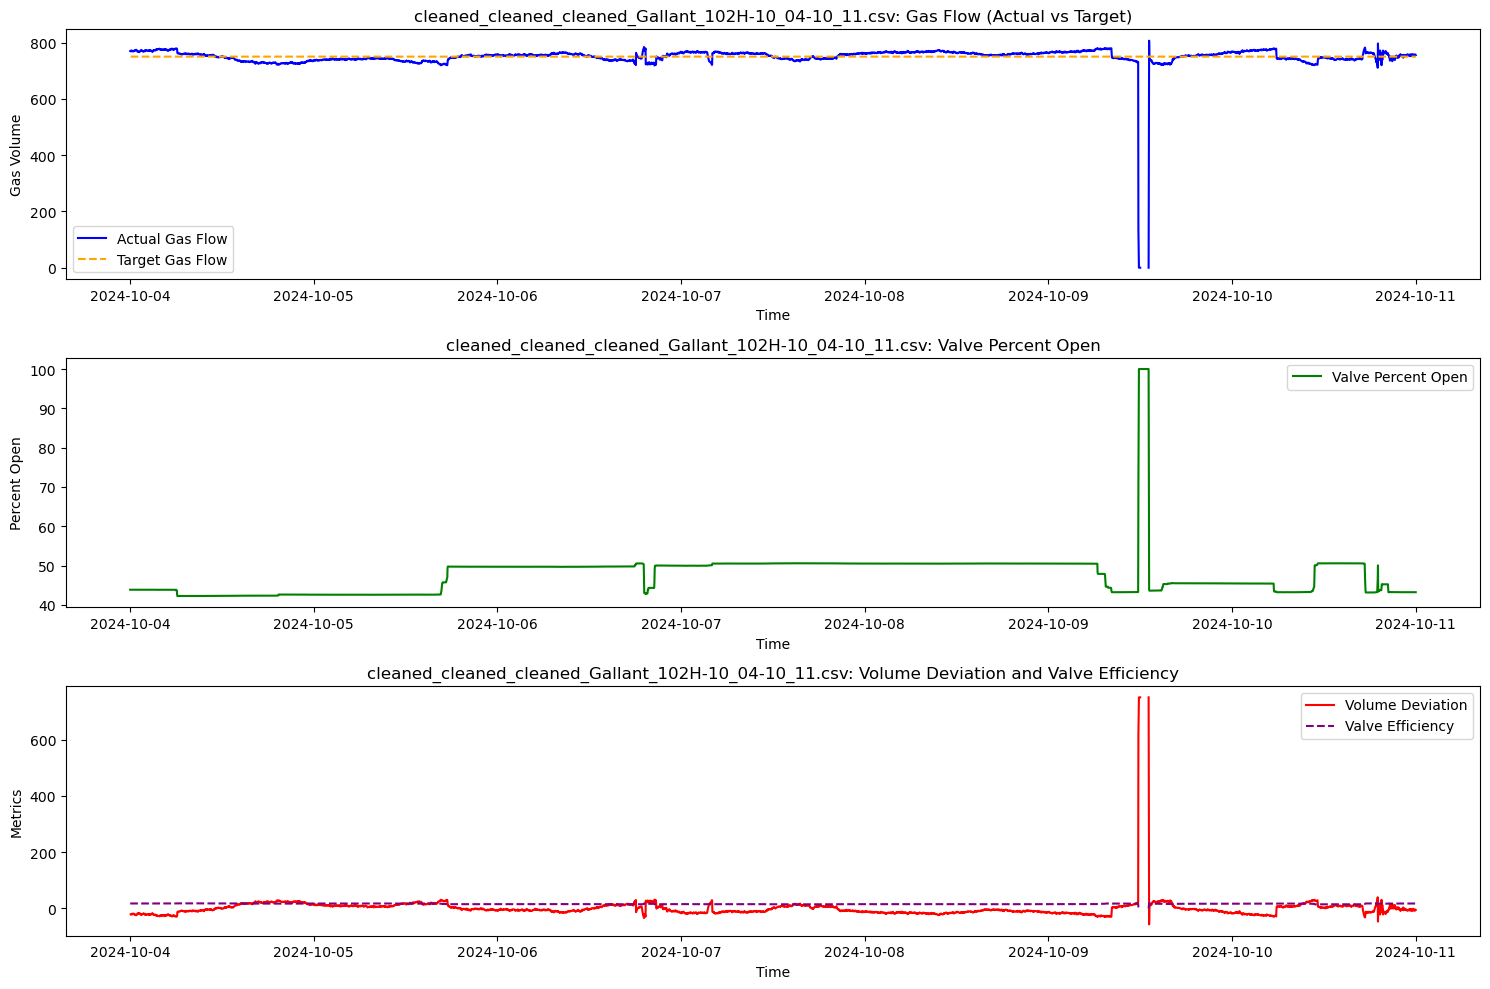

Processing file: cleaned_Courageous_729H-09_25-09_28.csv


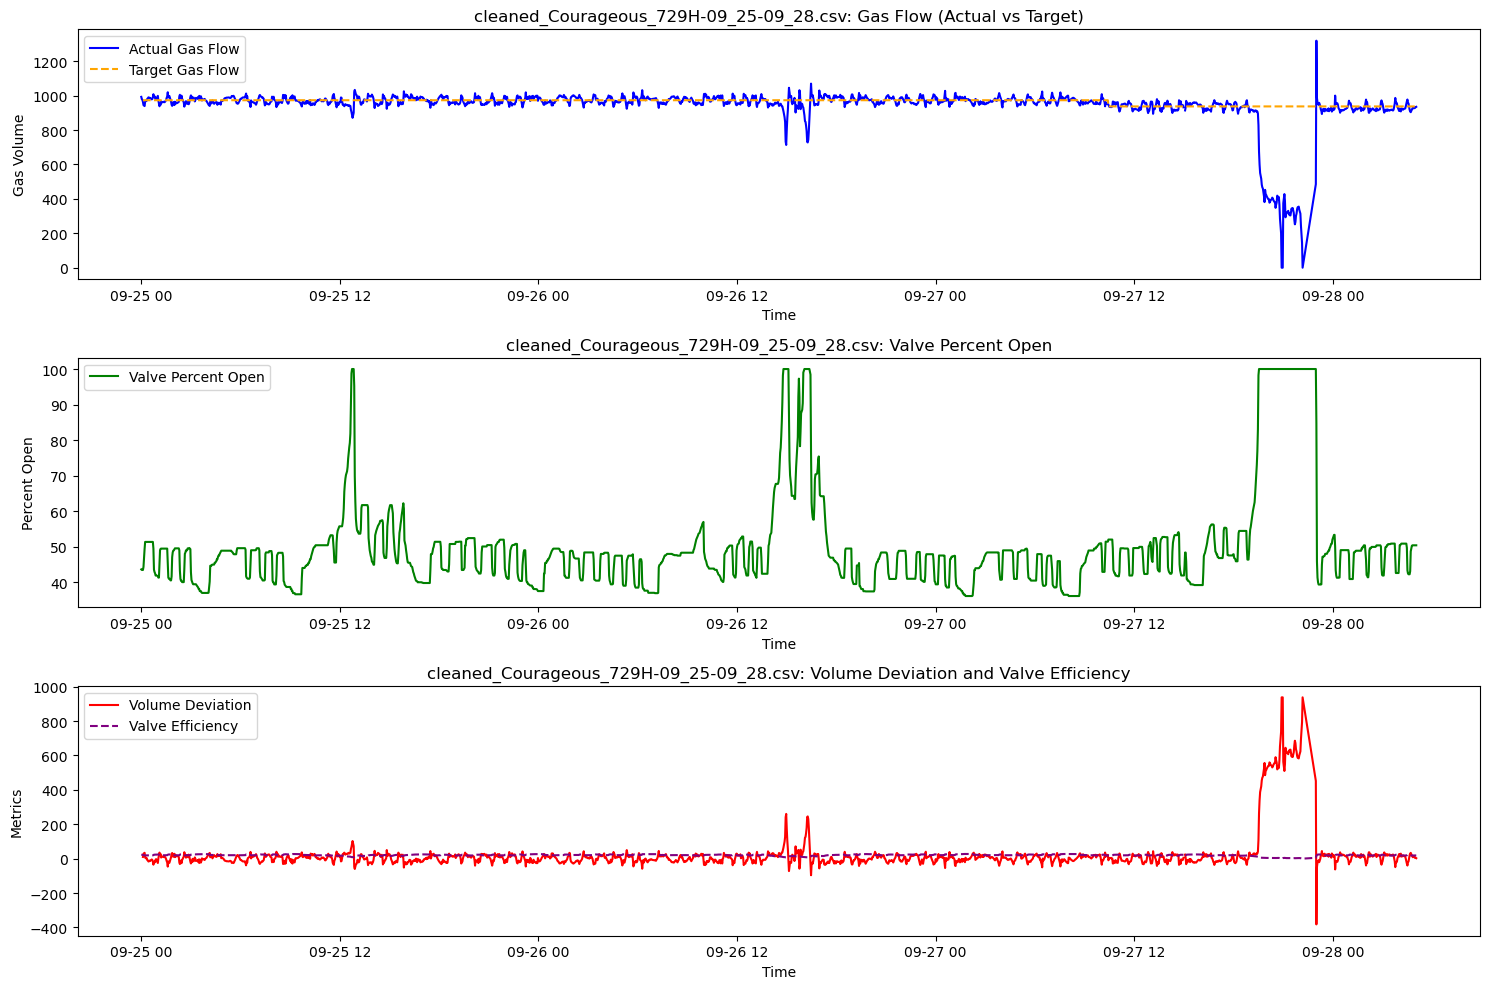

Processing file: cleaned_cleaned_cleaned_Noble_4H-10_24-10_29.csv


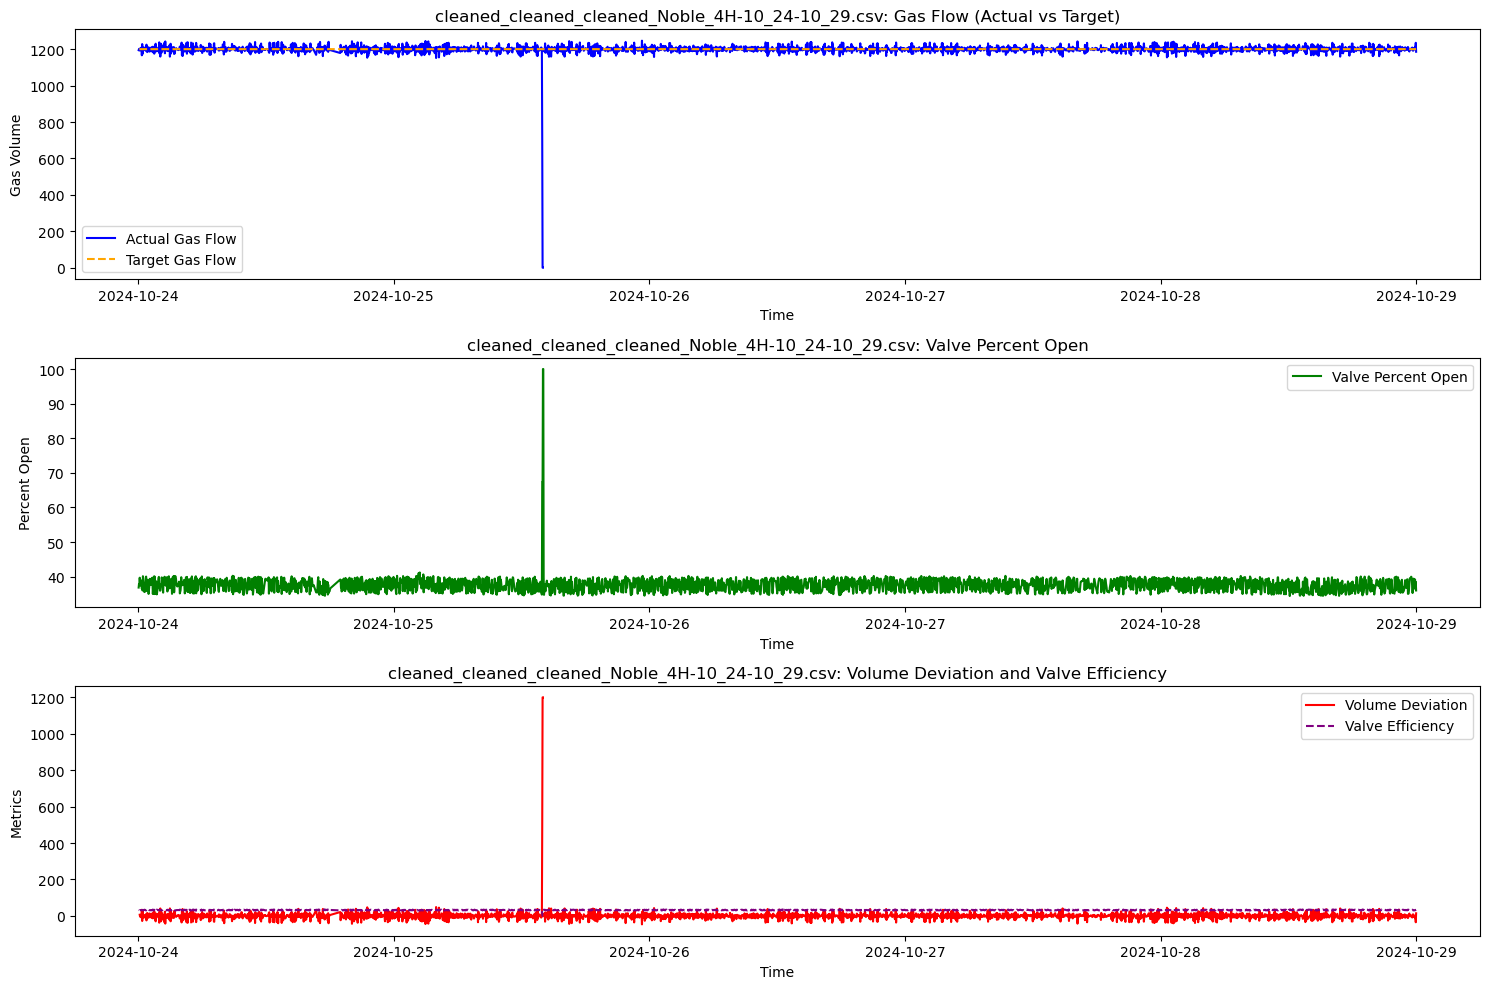

Processing file: cleaned_Resolute_728H-10_14-10_21.csv


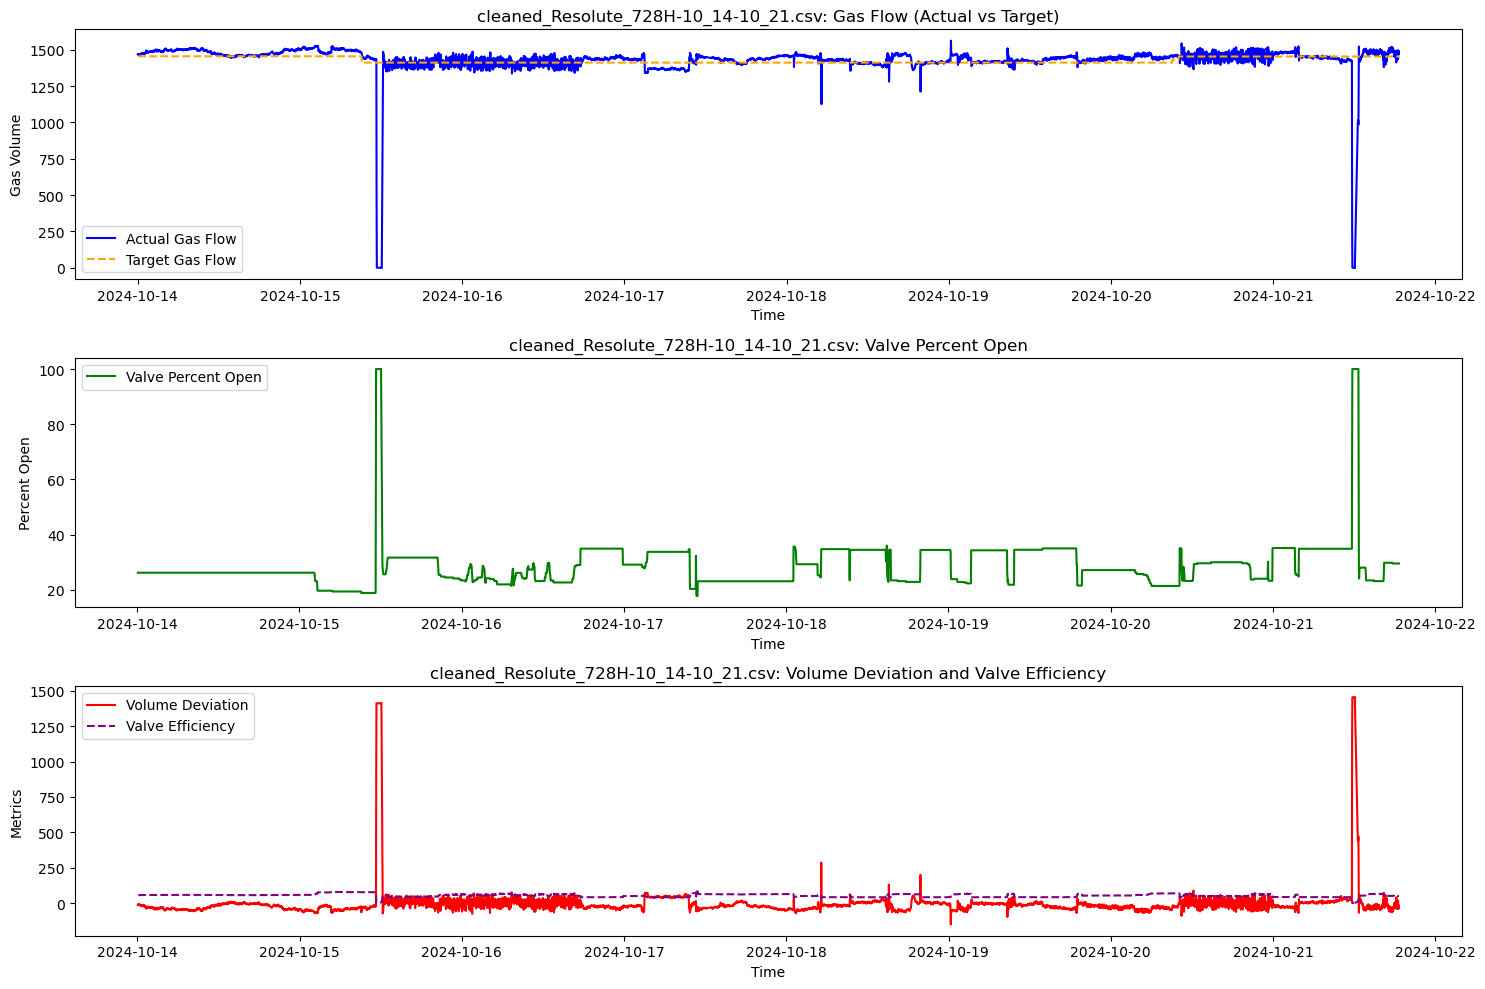

Processing file: cleaned_cleaned_cleaned_Fearless_709H-10_31-11_07.csv


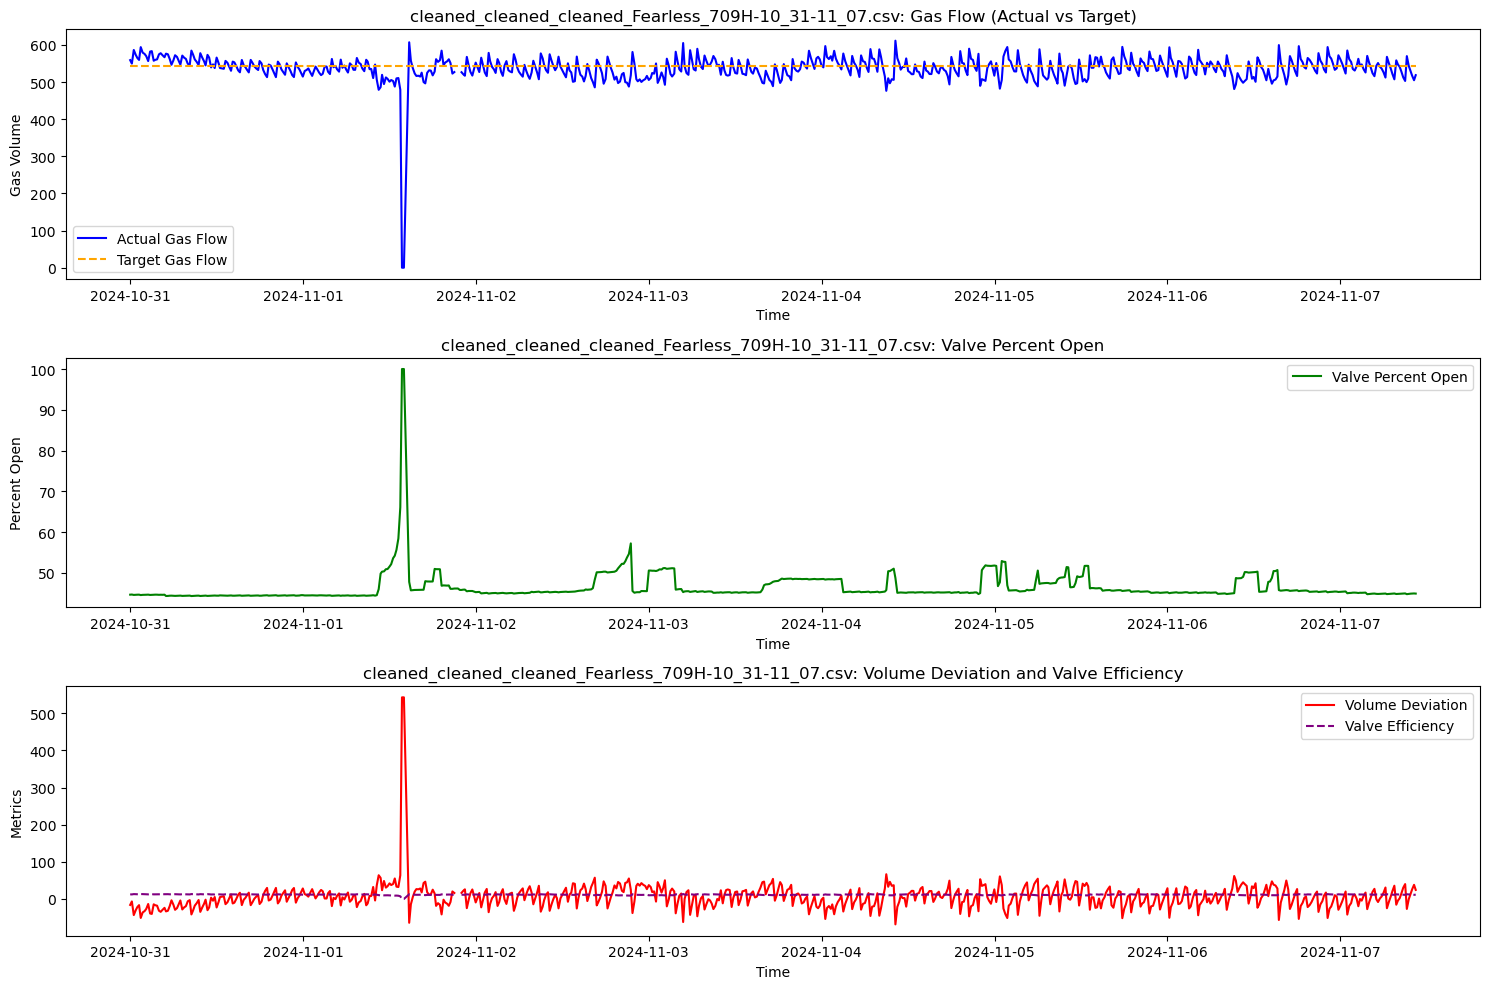

Processing file: cleaned_cleaned_Ruthless_745H-10_01-10_08.csv


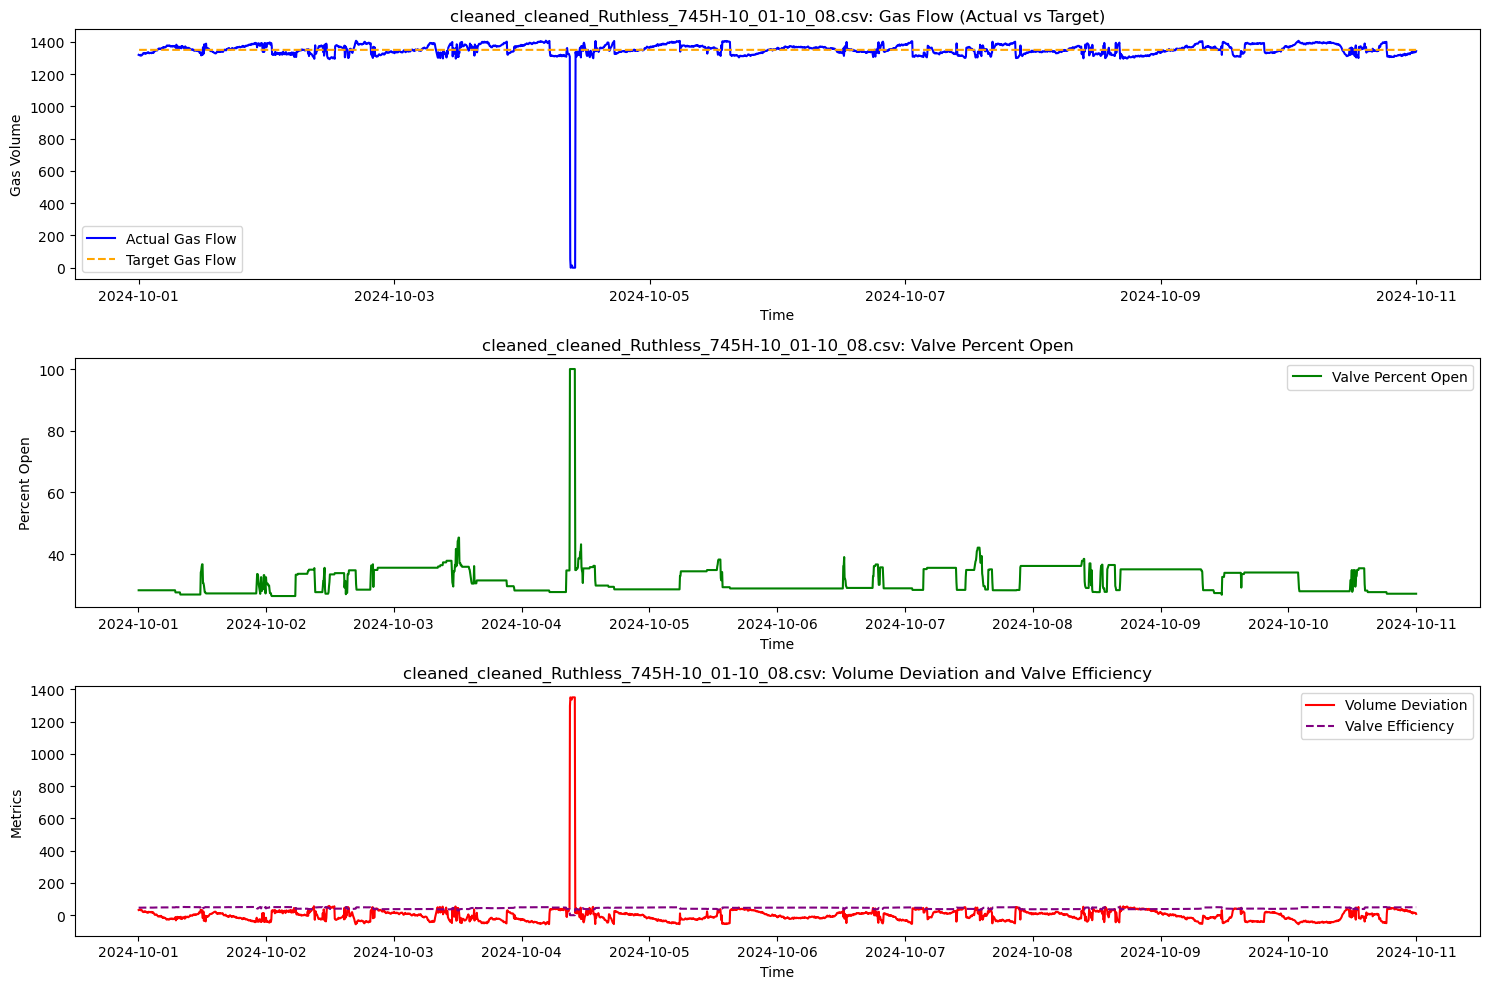

Processing file: cleaned_Gallant_102H-10_04-10_11.csv


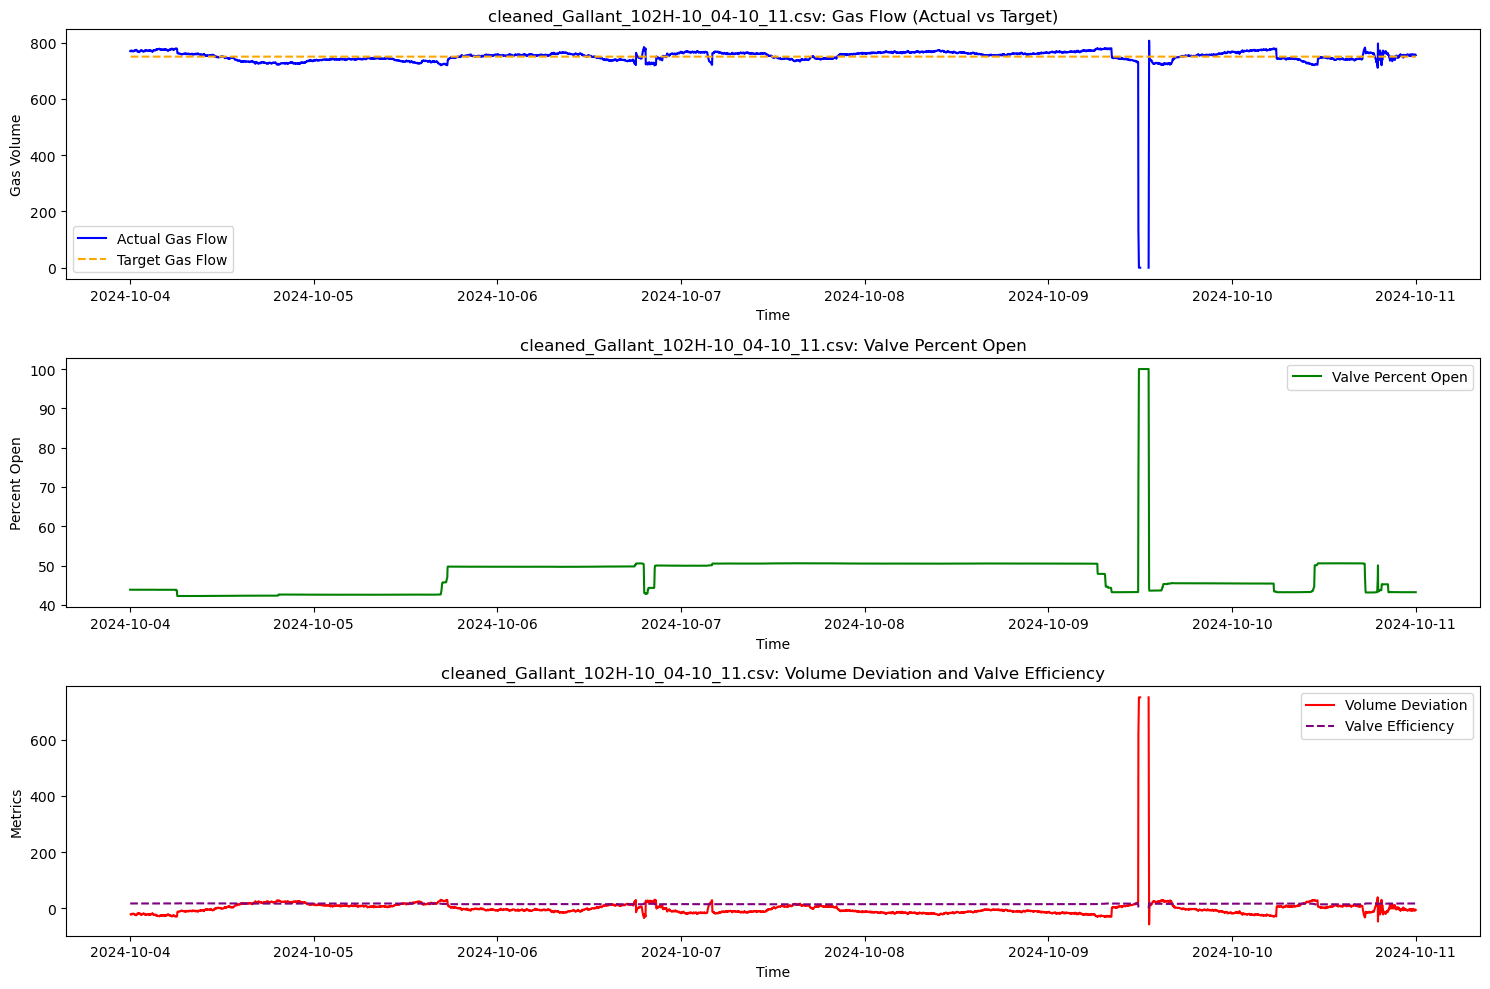

Processing file: cleaned_Steadfast_505H-10_30-11_07.csv


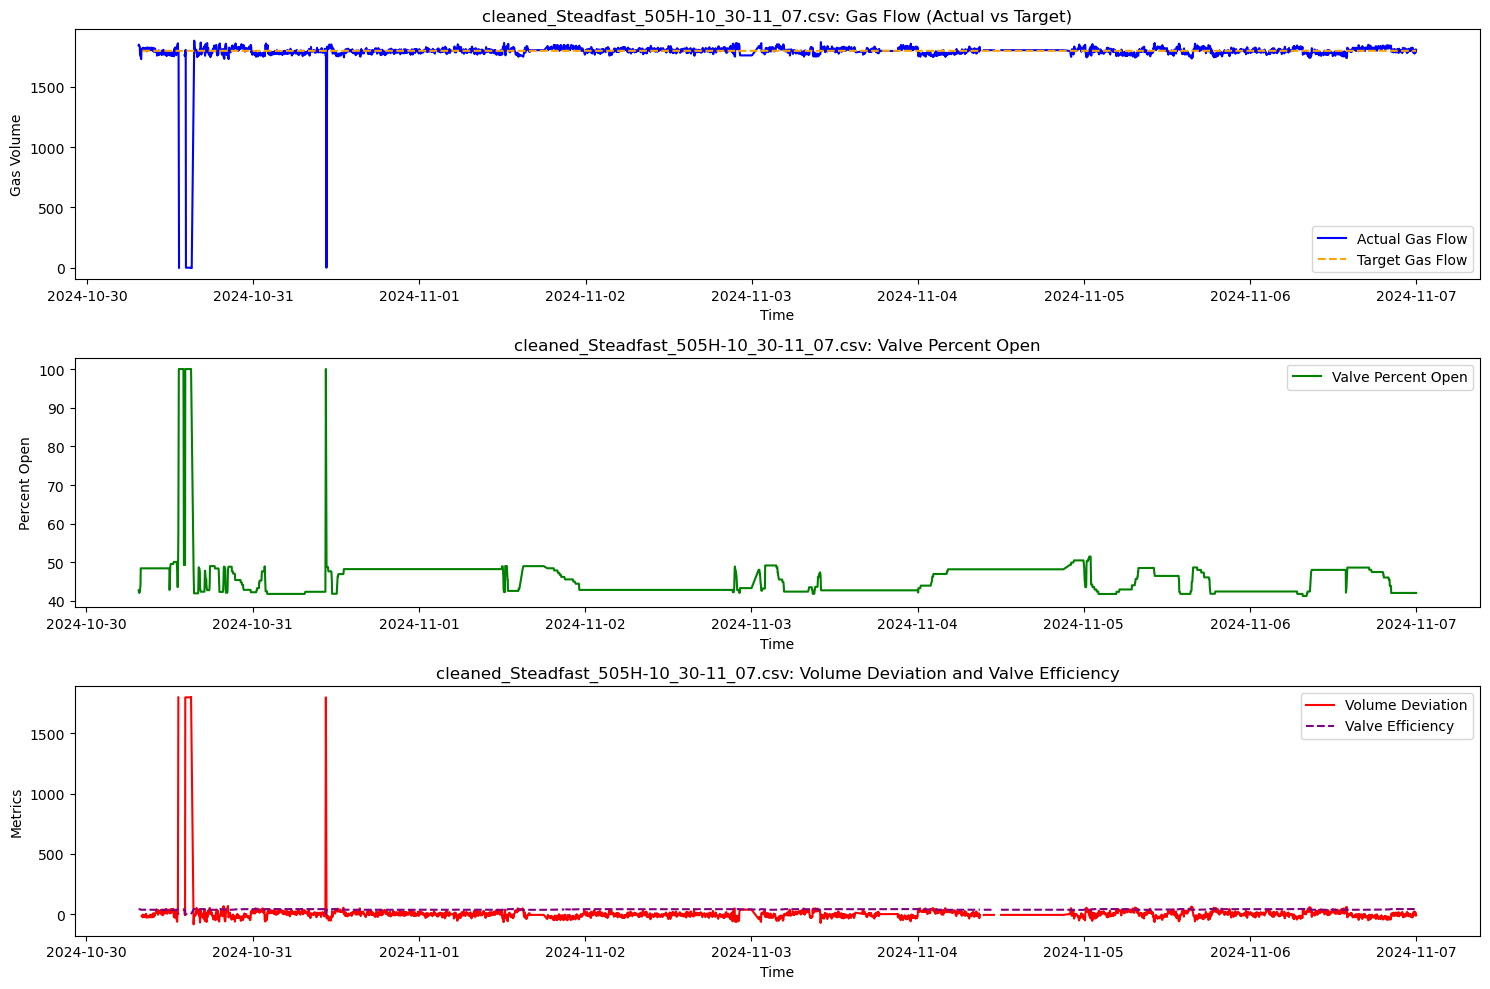

Processing file: cleaned_cleaned_Gallant_102H-10_04-10_11.csv


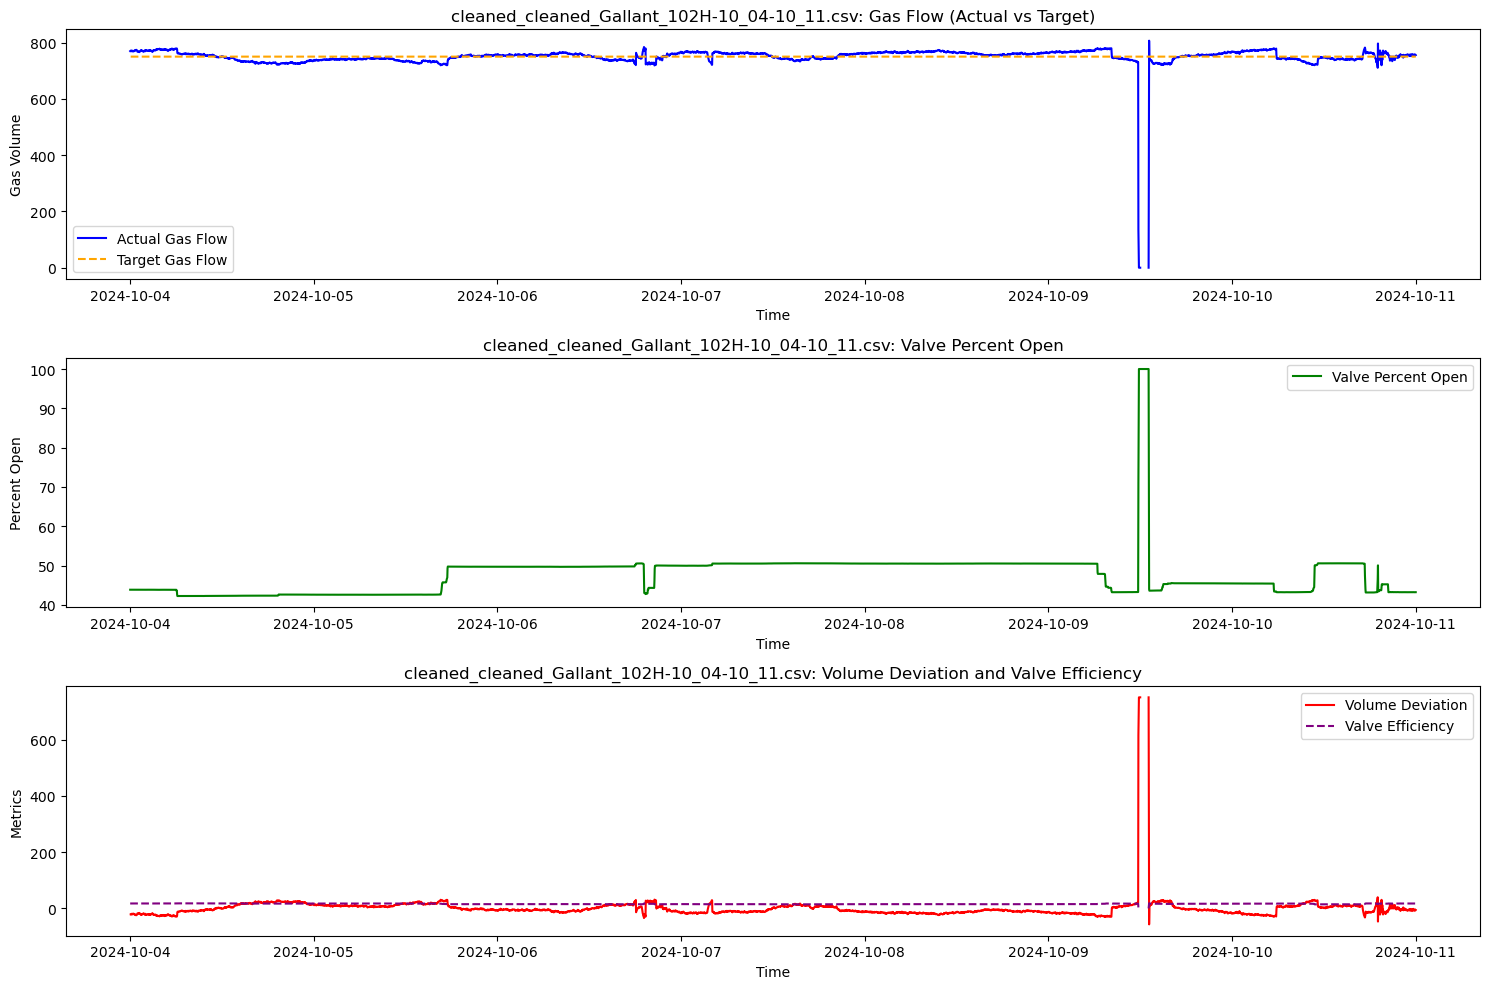

Processing file: cleaned_cleaned_cleaned_Valiant_505H-09_22-09_30.csv


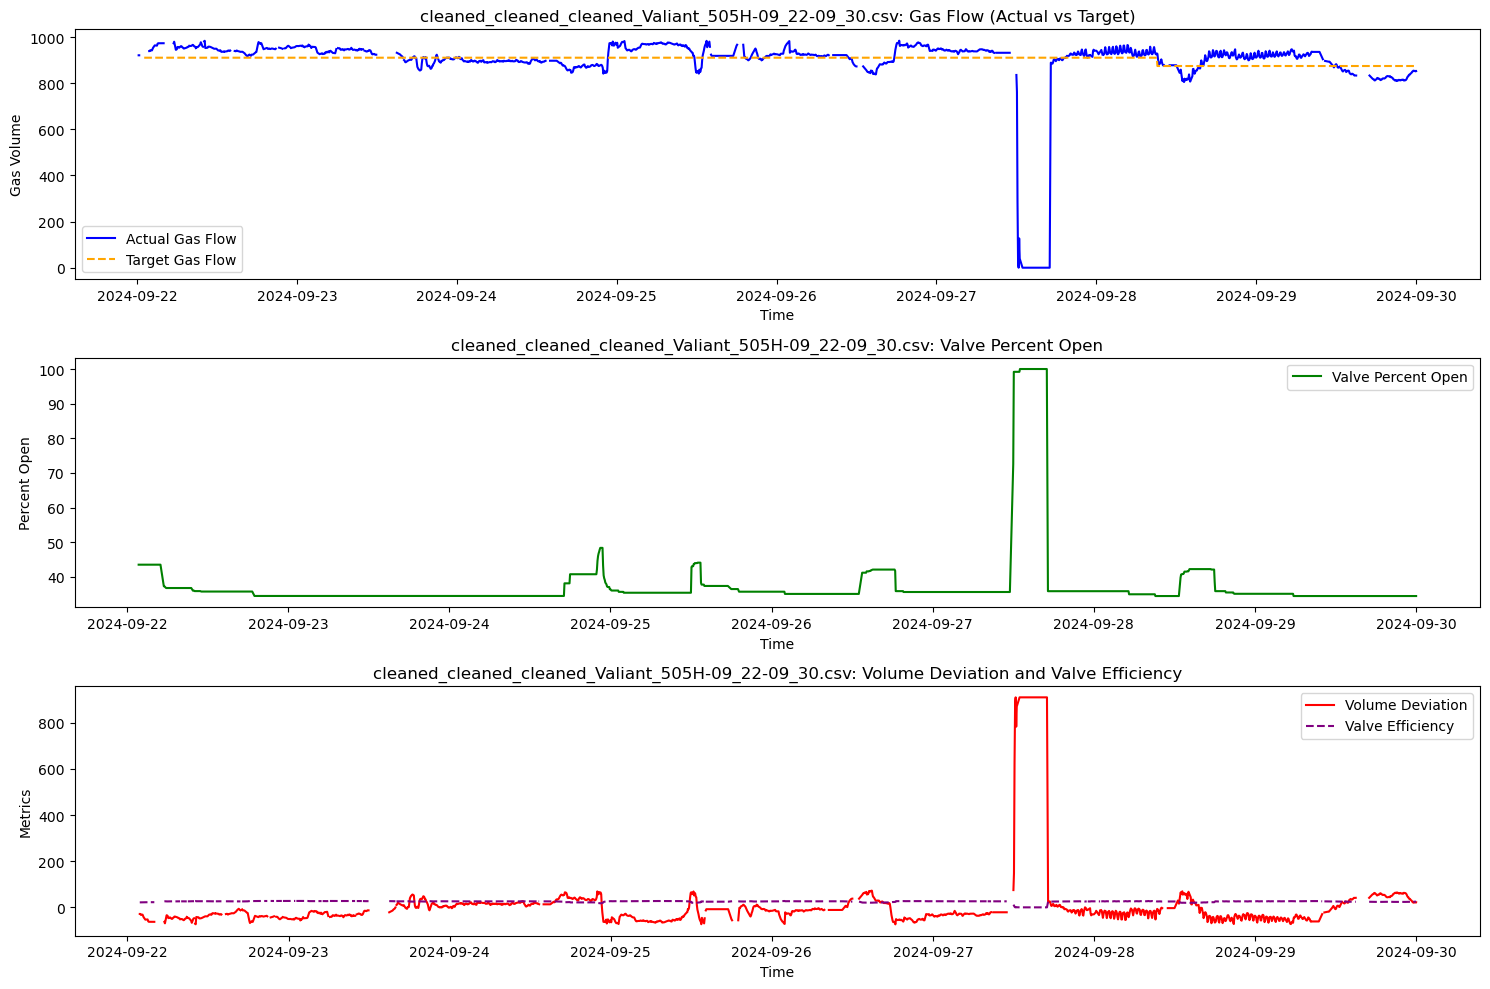

Processing file: cleaned_Bold_744H-10_31-11_07.csv


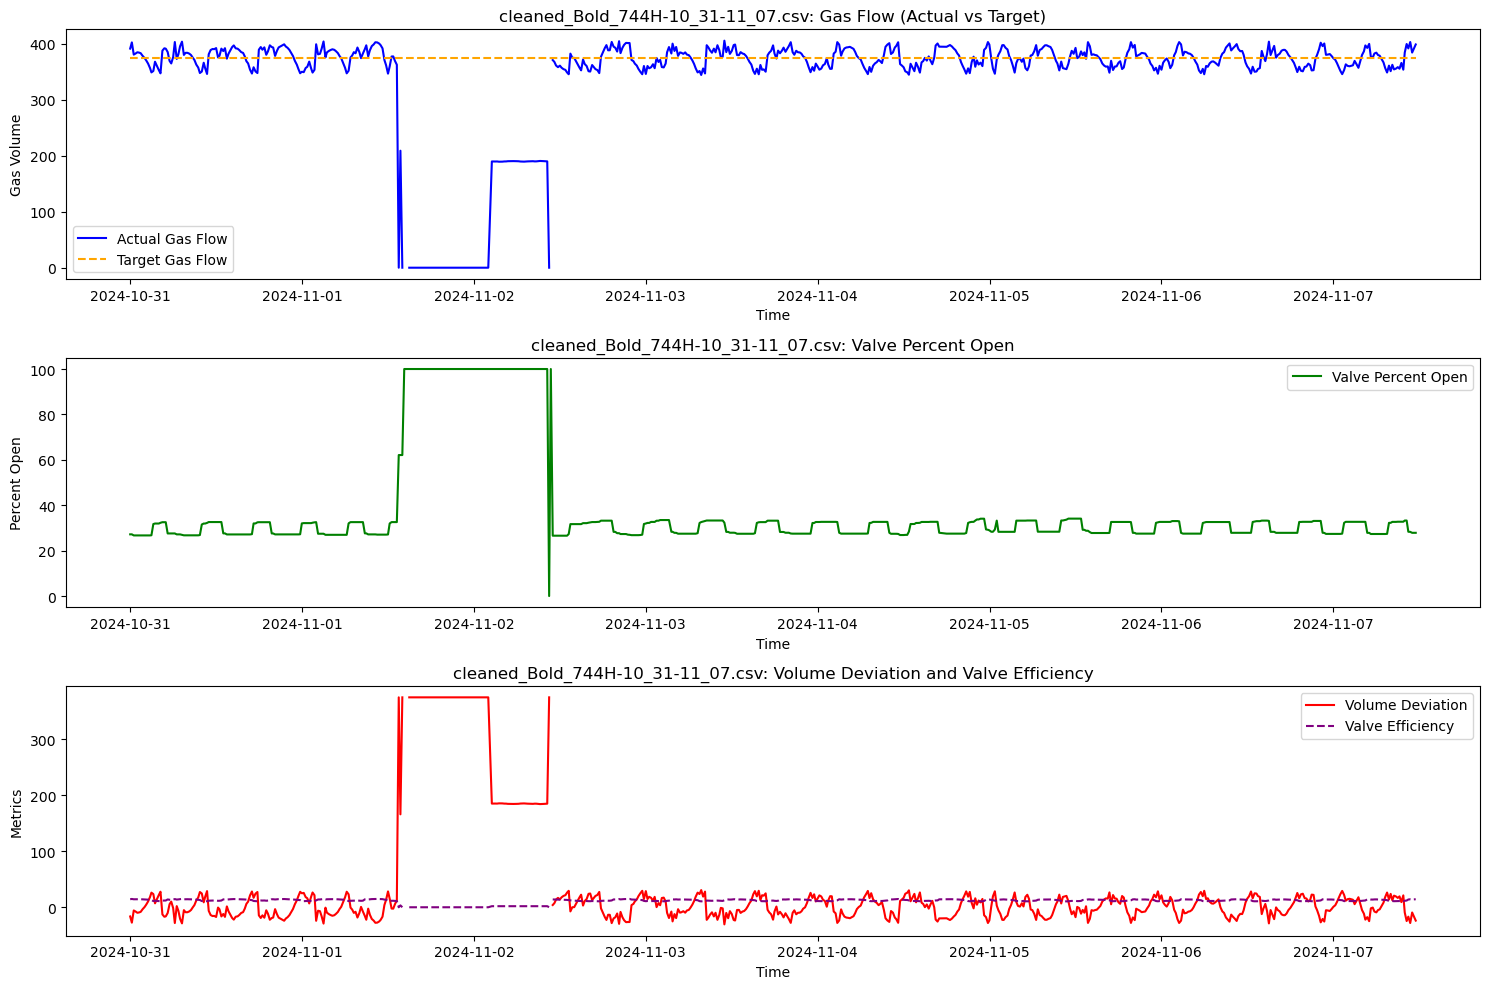

Processing file: cleaned_cleaned_cleaned_Resolute_728H-10_14-10_21.csv


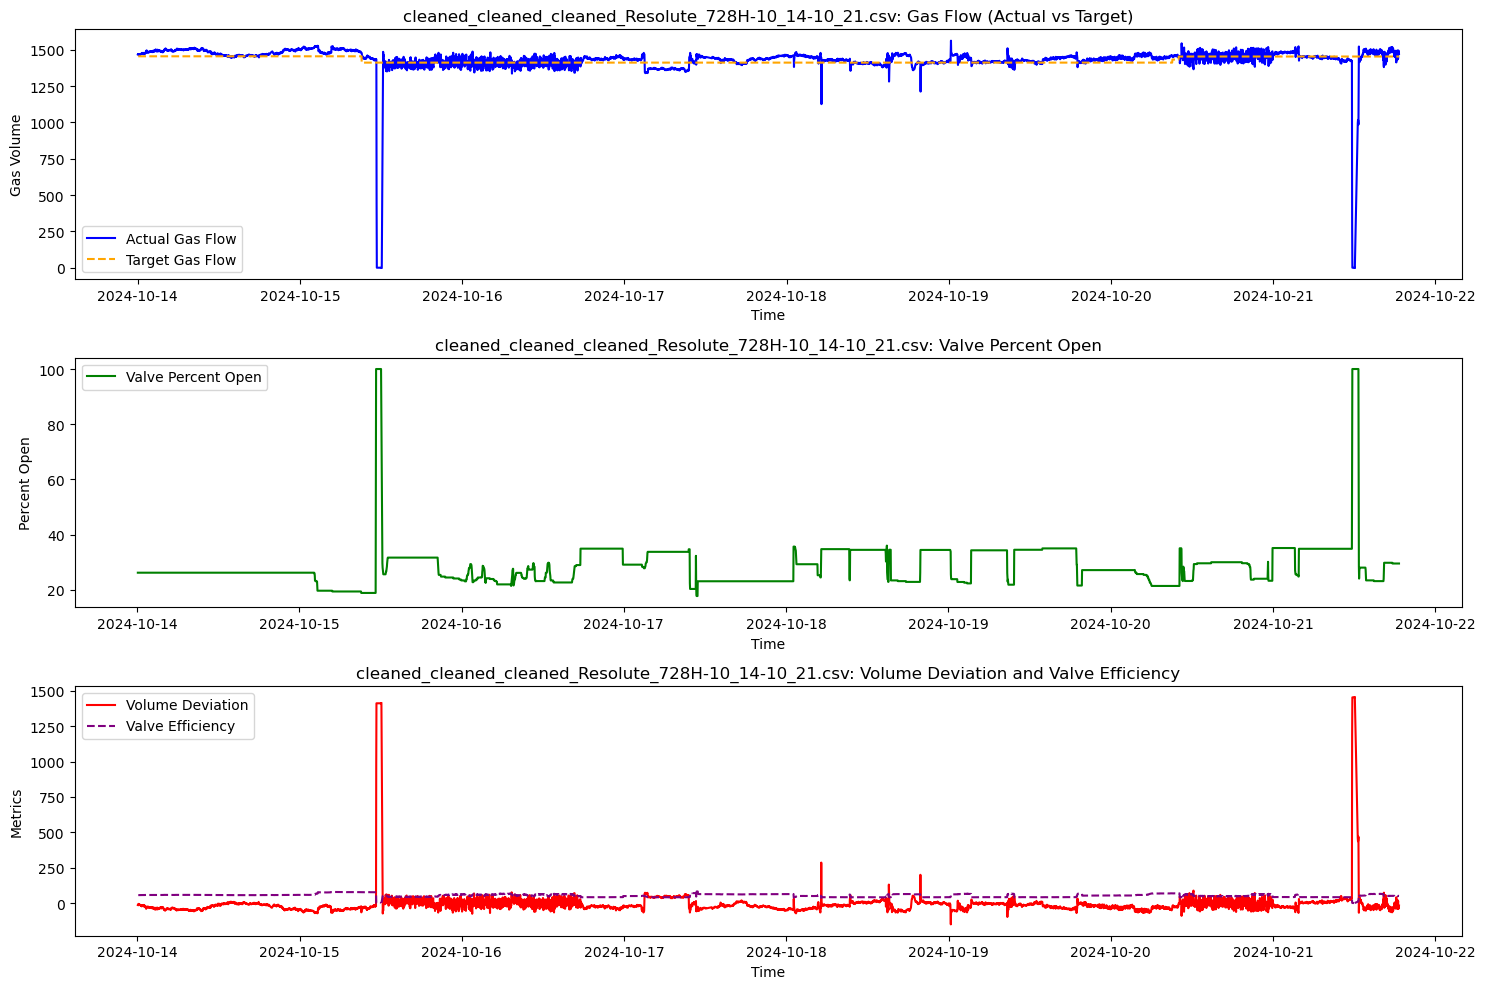

Processing file: cleaned_cleaned_Steadfast_505H-10_30-11_07.csv


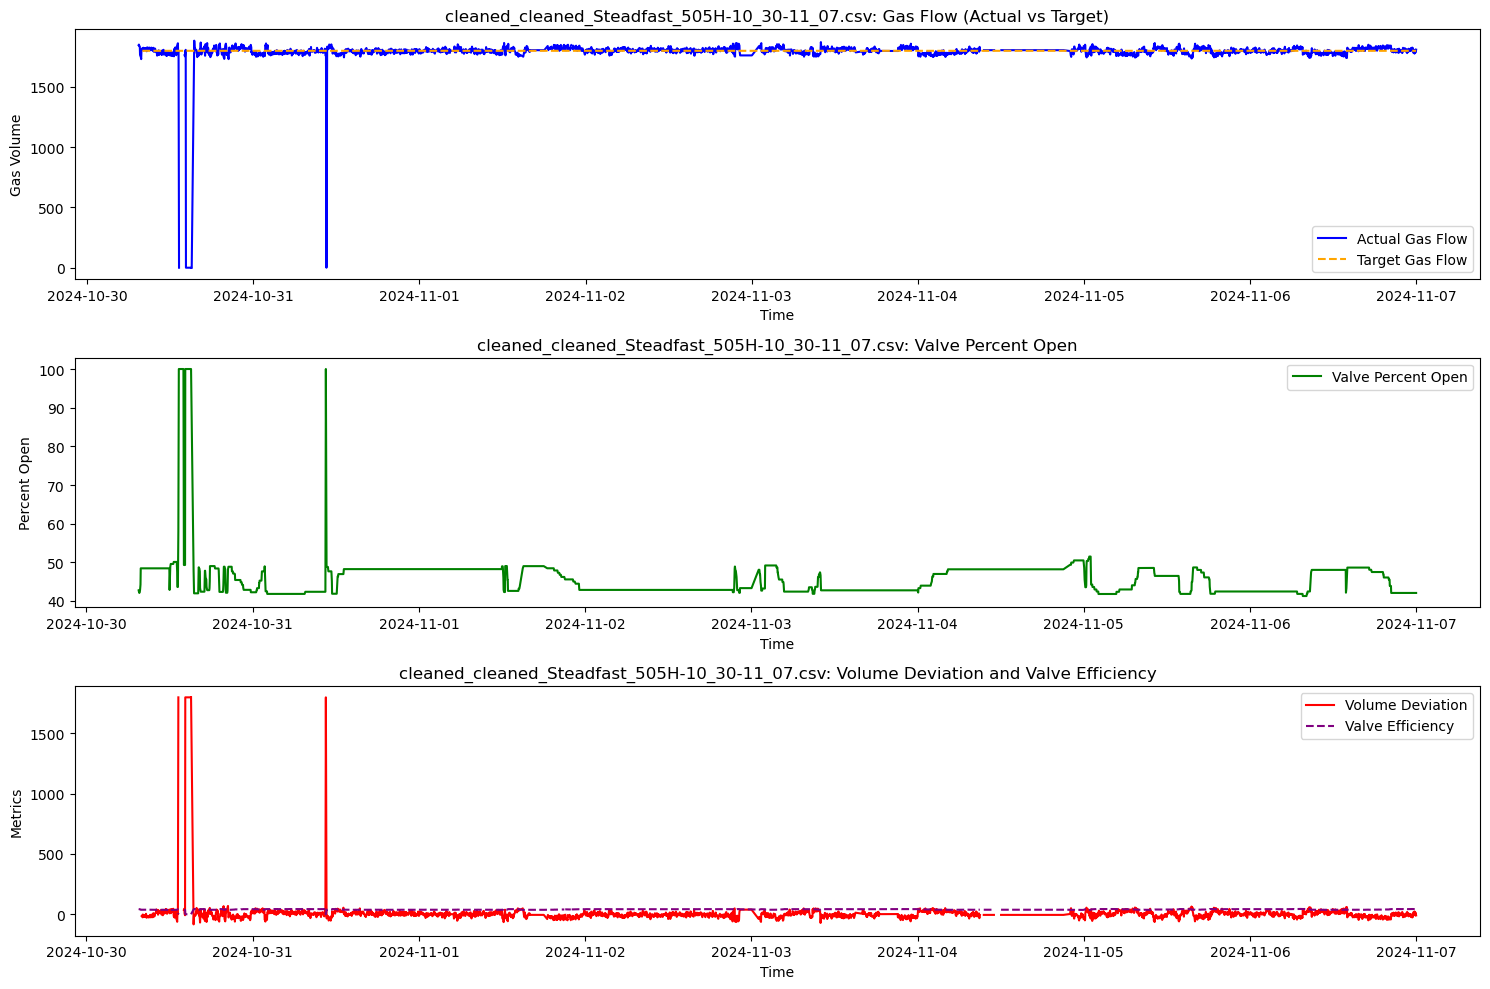

Processing file: cleaned_cleaned_cleaned_Bold_744H-10_31-11_07.csv


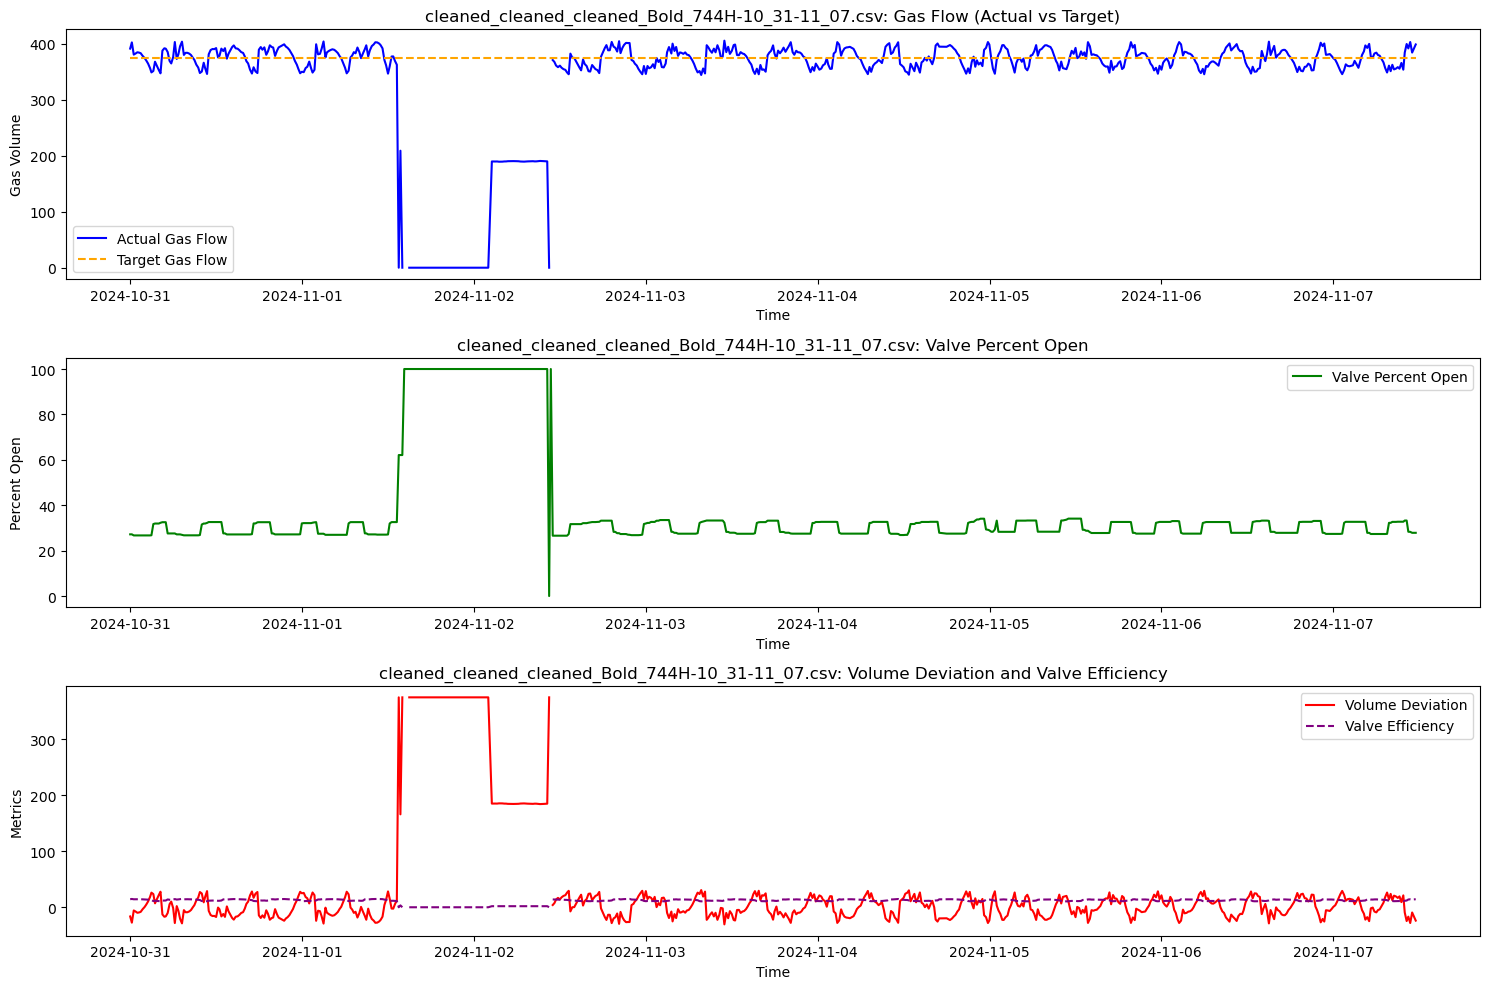

Processing file: cleaned_Fearless_709H-10_31-11_07.csv


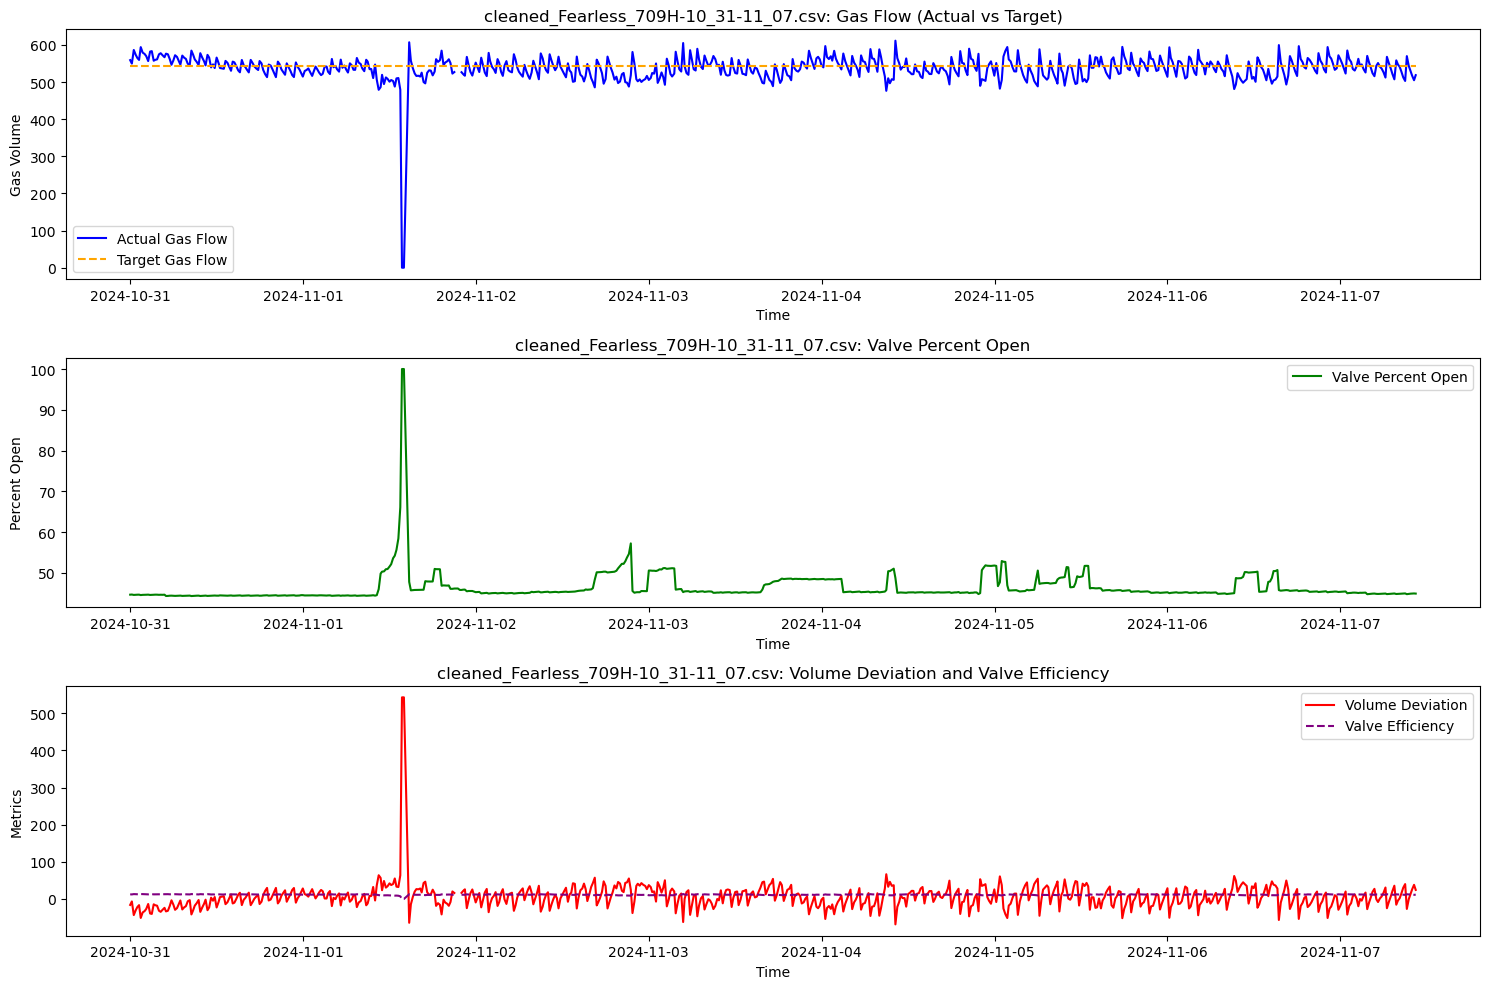

Processing file: cleaned_cleaned_Noble_4H-10_24-10_29.csv


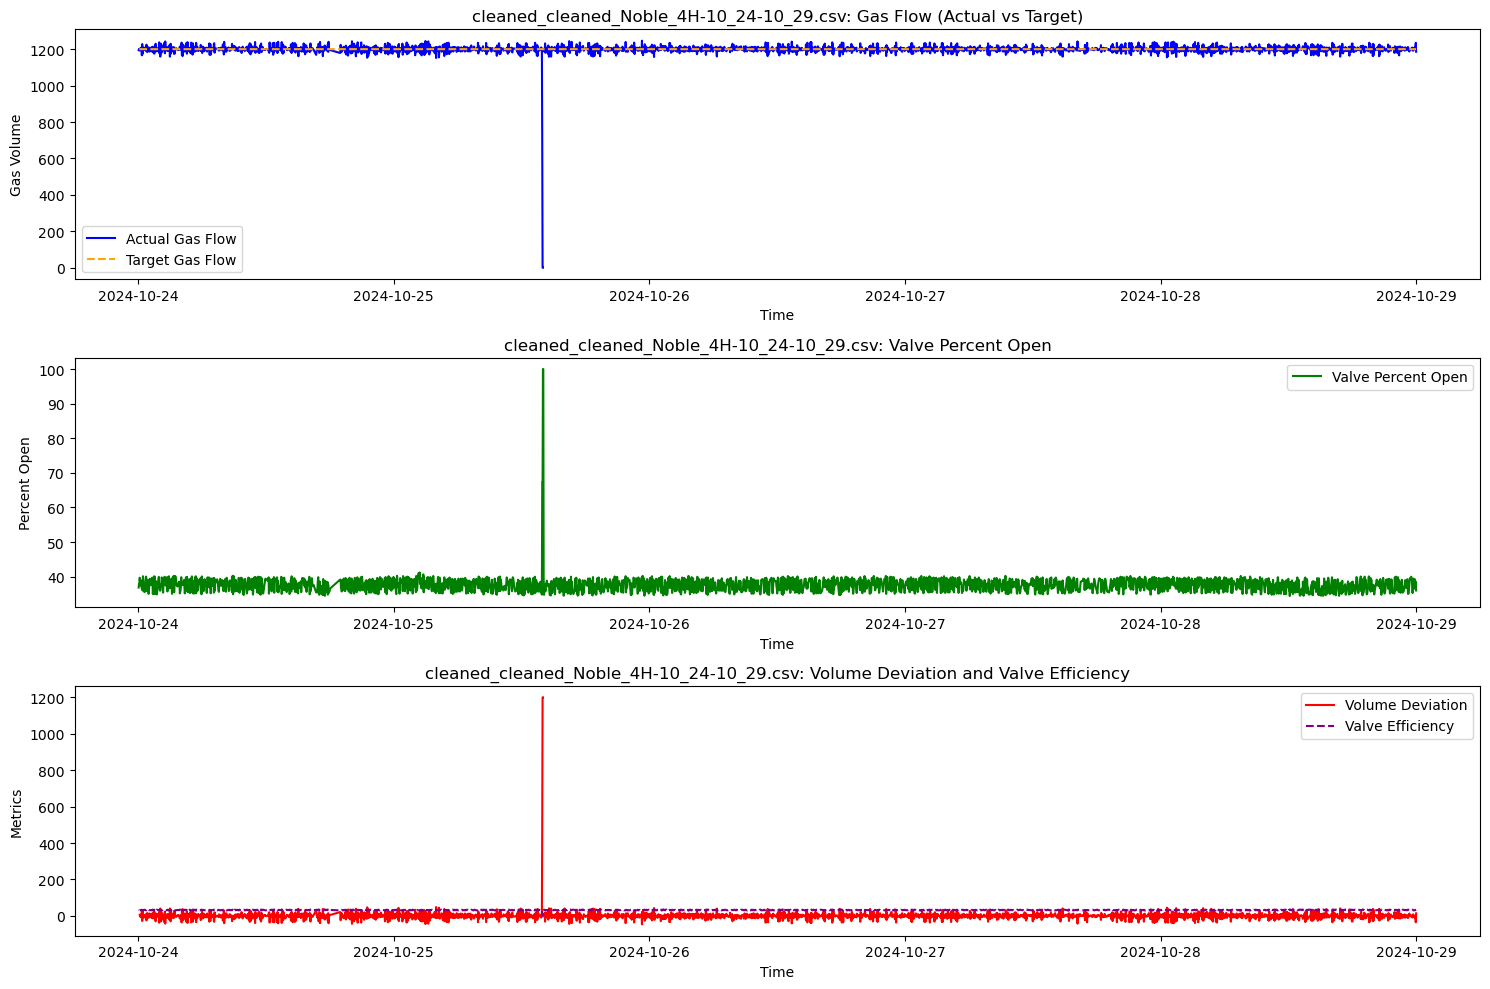

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Path to the Downloads folder
directory_path = "/Users/saicharanmerugu/Downloads/"  # Replace with your actual Downloads folder path

# Identify cleaned CSV files in the folder
cleaned_csv_files = [f for f in os.listdir(directory_path) if f.startswith('cleaned_') and f.endswith('.csv')]

# Function to plot metrics
def plot_metrics(df, title="Dataset"):
    # Convert 'Time' column to datetime for proper plotting
    df['Time'] = pd.to_datetime(df['Time'])
    
    # Plot Time-Series Data
    plt.figure(figsize=(15, 10))

    # Subplot 1: Actual vs Target Gas Flow
    plt.subplot(3, 1, 1)
    plt.plot(df['Time'], df['Inj Gas Meter Volume Instantaneous'], label='Actual Gas Flow', color='blue')
    plt.plot(df['Time'], df['Inj Gas Meter Volume Setpoint'], label='Target Gas Flow', color='orange', linestyle='--')
    plt.title(f'{title}: Gas Flow (Actual vs Target)')
    plt.xlabel('Time')
    plt.ylabel('Gas Volume')
    plt.legend()

    # Subplot 2: Valve Percent Open
    plt.subplot(3, 1, 2)
    plt.plot(df['Time'], df['Inj Gas Valve Percent Open'], label='Valve Percent Open', color='green')
    plt.title(f'{title}: Valve Percent Open')
    plt.xlabel('Time')
    plt.ylabel('Percent Open')
    plt.legend()

    # Subplot 3: Volume Deviation and Valve Efficiency
    plt.subplot(3, 1, 3)
    plt.plot(df['Time'], df['Volume Deviation'], label='Volume Deviation', color='red')
    plt.plot(df['Time'], df['Valve Efficiency'], label='Valve Efficiency', color='purple', linestyle='--')
    plt.title(f'{title}: Volume Deviation and Valve Efficiency')
    plt.xlabel('Time')
    plt.ylabel('Metrics')
    plt.legend()

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Loop through each cleaned file and visualize
for csv_file in cleaned_csv_files:
    file_path = os.path.join(directory_path, csv_file)
    print(f"Processing file: {csv_file}")
    
    # Load the CSV file
    df = pd.read_csv(file_path)
    
    # Plot the metrics for the dataset
    plot_metrics(df, title=csv_file)


In [12]:
import os
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
import matplotlib.pyplot as plt

# Define file path for CSV files
file_path = "./your_csv_directory/"  # Replace with the directory containing your CSV files
file_list = [os.path.join(file_path, file) for file in os.listdir(file_path) if file.endswith('.csv')]

# Step 1: Load and Combine Data
all_data = []

for file in file_list:
    print(f"Processing file: {file}")
    df = pd.read_csv(file)
    
    # Check for required columns (adjust based on your dataset)
    required_columns = ['Volume Deviation', 'Valve Efficiency']
    if not all(col in df.columns for col in required_columns):
        print(f"Skipping file {file}: Missing required columns")
        continue
    
    # Handle missing values
    df = df.interpolate(method='linear', limit_direction='forward')
    
    # Smoothing the data (rolling average)
    df['Volume Deviation'] = df['Volume Deviation'].rolling(window=5, min_periods=1).mean()
    df['Valve Efficiency'] = df['Valve Efficiency'].rolling(window=5, min_periods=1).mean()
    
    # Append cleaned data
    all_data.append(df[['Volume Deviation', 'Valve Efficiency']])

# Combine all data into a single DataFrame
combined_data = pd.concat(all_data, ignore_index=True)
print(f"Total data shape: {combined_data.shape}")

# Step 2: Temporalize Data
def temporalize(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback].values)
        y.append(data[i+lookback].values)
    return np.array(X), np.array(y)

lookback = 5  # Define the lookback window
X, y = temporalize(combined_data, lookback)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 3: Build the LSTM Model
n_features = X.shape[2]
model = Sequential([
    LSTM(128, activation='relu', input_shape=(lookback, n_features), return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    RepeatVector(lookback),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(128, activation='relu', return_sequences=True),
    TimeDistributed(Dense(n_features))
])



FileNotFoundError: [Errno 2] No such file or directory: './your_csv_directory/'

In [ ]:
model.compile(optimizer='adam', loss='mse')
model.summary()

# Step 4: Train the Model
history = model.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Step 5: Evaluate Reconstruction Errors
X_test_pred = model.predict(X_test)
reconstruction_error = np.mean(np.abs(X_test - X_test_pred), axis=(1, 2))

# Set a threshold for anomaly detection
threshold = np.mean(reconstruction_error) + 3 * np.std(reconstruction_error)
print(f"Anomaly Detection Threshold: {threshold}")

# Identify anomalies
anomalies = reconstruction_error > threshold
print(f"Anomalies Detected: {np.sum(anomalies)}")

# Step 6: Visualize Results
plt.figure(figsize=(15, 5))
plt.plot(reconstruction_error, label="Reconstruction Error")
plt.axhline(y=threshold, color='r', linestyle='--', label="Threshold")
plt.title("Reconstruction Error and Anomalies")
plt.legend()
plt.show()

# Optional: Highlight anomalies in test data
anomalous_data = X_test[anomalies]

# Step 7: Save the Model


In [ ]:
model.save("lstm_anomaly_detector_multiple_files.h5")